pip install category_encoders

# Startups operations/close predictions 

**Цель проекта** -  разработать модель для предсказания успешности стартапа (закроется или нет).

**Дополнительные задачи проекта:**
- Выделить важные компоненты из данных, влияющие на работу стартапов.
- На основе данных и графиков сформулировать рекомендации позволяющие повысить шанс на успех стартапа.
- Подготовить отчет по исследованию. 

**Источники данных**
- Тренировочный набор (около 53к записей). Набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'
kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- Тестовый набор. 
kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.
status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].

**Оценка качества предсказаний**
Метрикой в этом проекте является F1-Score.

**План проекта**:
 1. Загрузка и ознакомление с данными,
 2. Предварительная обработка данных. Устранение пропусков и дубликатов. Работа с форматами.
 3. Полноценный разведочный анализ.
 4. Разработка новых синтетических признаков,
 5. Проверка признаков на мультиколлинеарность,
 6. Отбор финального набора обучающих признаков.
 7. Построение пайплайна. Выбор и обучение моделей. 
 8. Итоговая оценка качества предсказания лучшей модели,
 9. Анализ важности признаков лучшей модели.
 10. Подготовка рекомендаций, позволяющих повысить шанс на успех стартапа.
 11. Подготовка отчета по исследованию.

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import sklearn

from scipy import stats as st
from math import factorial
from scipy.stats import binom

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    LabelEncoder
)


from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier

import category_encoders as ce

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    make_scorer
)

In [3]:
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay

from itertools import combinations
from scipy.spatial.distance import euclidean,cityblock

from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif 


import time
from scipy.stats import pearsonr
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [5]:
import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution


In [6]:
import shap

In [7]:
from sklearn.linear_model import Ridge

In [8]:
print(sklearn.__version__)

1.3.0


In [9]:
import warnings
warnings.filterwarnings("ignore")           

In [10]:
github_url_1 = 1
dates_columns_train = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

try:
    df_kaggle_startups_train = pd.read_csv('kaggle_startups_train_27042024.csv', decimal=',', parse_dates=dates_columns_train)
except:
    df_kaggle_startups_train = pd.read_csv(github_url_1, decimal=',', parse_dates=dates_columns_train)

**Не забыть сделать альтернативную загрузку тут и ниже после загрузки в github**

github_url_1 = 1

try:
    df_kaggle_startups_train = pd.read_csv('kaggle_startups_train_27042024.csv', decimal=',', parse_dates=dates_columns_train)
except:
    df_kaggle_startups_train = pd.read_csv(github_url_1, decimal=',', parse_dates=dates_columns_train)

In [11]:
df_kaggle_startups_train.sample(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
31671,Kailos Genetics,Biotechnology,1900000.0,operating,USA,AL,Huntsville,Huntsville,1,2010-01-01,2011-12-05,2011-12-05,NaT
36576,ActX,Biotechnology,2670394.0,operating,USA,WA,Seattle,Seattle,2,2012-01-01,2014-01-12,2014-07-18,NaT
15709,NextCommerce,Curated Web|Price Comparison,3000000.0,operating,AUS,2,Sydney,Sydney,2,2012-01-01,2014-01-26,2015-03-06,NaT
51913,Hatch Baby,Consumer Electronics,7000000.0,operating,USA,CA,SF Bay Area,Menlo Park,1,2014-11-26,2015-10-15,2015-10-15,NaT
13866,Xambala,Finance,65548214.0,operating,USA,CA,SF Bay Area,Sunnyvale,7,2001-01-01,2004-06-30,2014-06-05,NaT


In [12]:
df_kaggle_startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  object        
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: datetime64[ns](4), int64(1), object(8)
memory usage: 5.2+ 

Признаки соответствуют описанию

In [13]:
github_url_2 = 2
dates_columns_test = ['founded_at', 'first_funding_at', 'last_funding_at']

try:
    df_kaggle_startups_test = pd.read_csv('kaggle_startups_test_27042024.csv', decimal=',', parse_dates=dates_columns_test)
except:
    df_kaggle_startups_test = pd.read_csv(github_url_2, decimal=',', parse_dates=dates_columns_test)

In [14]:
df_kaggle_startups_test.sample(5)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
9767,Oobedoo Ltd,NaN,1396590.79247142,NaN,NaN,NaN,NaN,1,2013-11-07,2015-02-14,2015-02-14,1100
6717,Medivie Therapeutics,Dental|Fitness|Health and Wellness|Medical|Med...,870000.0,GBR,F8,London,Hemel Hempstead,1,2011-07-01,2014-07-31,2014-07-31,2376
6393,Nukona,Enterprise Software,206800.0,USA,CA,San Diego,Solana Beach,3,2009-07-07,2010-11-08,2011-09-21,3100
6214,Guanya Education Group,Education,4000000.0,CHN,7,CHN - Other,Sheyang,1,2008-12-19,2010-10-25,2010-10-25,3300
11651,Kallikids,Kids|Parenting|Services,175000.0,GBR,E2,London,Brighton,1,2014-09-24,2015-04-14,2015-04-14,756


In [15]:
df_kaggle_startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  object        
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   founded_at         13125 non-null  datetime64[ns]
 9   first_funding_at   13125 non-null  datetime64[ns]
 10  last_funding_at    13125 non-null  datetime64[ns]
 11  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](3), int64(2), object(7)
memory usage: 1.2+ MB


In [16]:
try:
    df_kaggle_startups_sample_submit = pd.read_csv('kaggle_startups_sample_submit_27042024.csv', decimal=',')
except:
    df_kaggle_startups_sample_submit = pd.read_csv(github_url_2, decimal=',')

In [17]:
df_kaggle_startups_sample_submit.sample(5)

,name,status
2457,WorkFusion,closed
2128,Singld Out,operating
2643,YouHelp,operating
4577,U.S. Photonics,operating
11465,Appetas,closed


In [18]:
df_kaggle_startups_sample_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


**Итого по разделу. Данные 3 датасетов загружены, признаки соответствуют описанию.**

### Предобработка данных

Создадим функции для предобработки

In [19]:
def check_df(df):
    """
    Проверяет pandas DataFrame на наличие пропущенных значений и дубликатов.
    
    Параметры:
    df (pandas.DataFrame): DataFrame для проверки.
    
    Выводит:
    - информацию о DataFrame,
    - количество и распределение пропущенных значений,
    - количество явных дубликатов,
    - первые пять строк DataFrame.
    """
    print("Общая инфо:")
    df.info()
    
    print("\nПроверка на наличие пропусков:")
    null_values = df.isnull().sum()
    if null_values.sum() > 0:
            print("В датафрейме есть пропущенные значения:")
            print(null_values)
    else:
        print("Пропущенные значения в датафрейме отсутствуют.")
    
    print("\nПроверка на наличие дубликатов:")
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"В датафрейме найдено {duplicates} явных дубликатов.")
    else:
        print("Явные дубликаты в датафрейме отсутствуют.")
    
    display(df.head())

# Для получения документации функции использовать:
#help(check_df)

In [20]:
# Создадим функцию для поиска уникальных значений в категориальных столбцах
def unique_value(df):
    column_list=df.select_dtypes(exclude='number').columns.tolist()
    for i in column_list:
        print(f"Уникальные значения {i}: {df[i].unique()}")  

In [21]:
check_df(df_kaggle_startups_train)
    

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  object        
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: datetime64[ns](4), int64(1), object(8)
memory 

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT


Избавимся от выявленных пропусков. Для обучения нам пригодятся столбцы country_code и funding_total_usd    

In [22]:
#Создадим отдельные датасеты в разрезе целевого признака
df_kaggle_startups_train_close=df_kaggle_startups_train.query('status=="closed"')
df_kaggle_startups_train_open=df_kaggle_startups_train.query('status=="operating"')

In [23]:
most_frequent_country_code=df_kaggle_startups_train_close['country_code'].mode()[0]
most_frequent_country_code

'USA'

In [24]:
most_frequent_country_code=df_kaggle_startups_train_open['country_code'].mode()[0]
most_frequent_country_code

'USA'

Мода country_code для в разрезе целевого признака не отличается.

In [25]:
# Определим моду в столбце 'country_code'
most_frequent_country_code = df_kaggle_startups_train['country_code'].mode()[0]

# Заменим 
df_kaggle_startups_train['country_code'].fillna(most_frequent_country_code, inplace=True)

# Проверим
print(df_kaggle_startups_train['country_code'].isnull().sum())

0


In [26]:
median_funding_total_usd_close=df_kaggle_startups_train_close['funding_total_usd'].median()
median_funding_total_usd_close

1300000.0

In [27]:
median_funding_total_usd_open=df_kaggle_startups_train_open['funding_total_usd'].median()
median_funding_total_usd_open

2000000.0

In [28]:
# Напишем функцию для замены пустых значений признака funding_total_usd на медиану в разрезе целевого признака

def most_frequent(row): 
    stat = row['status']
    funding = row['funding_total_usd']
    if pd.isnull(funding):
        if stat == 'closed':
            return median_funding_total_usd_close
        elif stat == 'operating':
            return median_funding_total_usd_open
        else:
            print(f"Неизвестный статус: {stat}")
    return funding

# Применим функцию к DataFrame
df_kaggle_startups_train['funding_total_usd'] = df_kaggle_startups_train.apply(most_frequent, axis=1)

# Проверка результатов
print(df_kaggle_startups_train['funding_total_usd'].isnull().sum())

# Проверим пропуски перед и после замены
initial_nulls = df_kaggle_startups_train['funding_total_usd'].isnull().sum()
df_kaggle_startups_train['funding_total_usd'] = df_kaggle_startups_train.apply(most_frequent, axis=1)
final_nulls = df_kaggle_startups_train['funding_total_usd'].isnull().sum()

print(f"Начальное количество пропусков: {initial_nulls}")
print(f"Конечное количество пропусков: {final_nulls}")

# Вывод строк с пропусками
print(df_kaggle_startups_train[df_kaggle_startups_train['funding_total_usd'].isnull()])

0
Начальное количество пропусков: 0
Конечное количество пропусков: 0
Empty DataFrame
Columns: [name, category_list, funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at]
Index: []


Исправим форматы сл. признаков:
- funding_total_usd
- funding_rounds

In [29]:
df_kaggle_startups_train['funding_total_usd'] = pd.to_numeric(
    df_kaggle_startups_train['funding_total_usd'], 
    errors='coerce'
    )

In [30]:
df_kaggle_startups_train['funding_rounds'] = pd.to_numeric(
    df_kaggle_startups_train['funding_rounds'], 
    errors='coerce'
    )

In [31]:
check_df(df_kaggle_startups_train)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  52514 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       52514 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), objec

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,USA,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT


In [32]:
# Убедимся что имена компаний-стартапов уникальны т.к. вероятно мы будет использовать их в качестве ключа
df_kaggle_startups_train['name'].duplicated().sum()

0

In [33]:
df_kaggle_startups_train[df_kaggle_startups_train['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-03-31


In [34]:
# Поставим загрушку на пустое значение ключа
df_kaggle_startups_train['name']=df_kaggle_startups_train['name'].fillna('Отсутствует')

In [35]:
df_kaggle_startups_train[df_kaggle_startups_train['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


In [36]:
df_kaggle_startups_train['category_list'].nunique()

22108

Наблюдаем 22109 уникальных значений. При кодировании признака и использовании его в качестве входящего в моделировании в дальшейшем возникнут проблемы. Попробуем решить эту проблему укрупнив категории

In [37]:
#Создадим заглушку для значений nan признака category_list
df_kaggle_startups_train['category_list'] = df_kaggle_startups_train['category_list'].fillna('Отсутствует')

In [38]:
# Создадим список категорий, повзаимствованный из Ycombinator
yc_categories = [
    "Analytics", "Engineering", "Product", "Design", "Finance", "Accounting", "Human Resources", "Infrastructure",
    "Legal", "Marketing", "Office Management", "Operations", "Productivity", "Recruiting", "Talent", "Retail", "Sales",
    "Security", "Supply Chain", "Logistics", "Education", "Fintech", "Asset Management", "Banking and Exchange",
    "Consumer Finance", "Credit and Lending", "Insurance", "Payments", "Consumer", "Apparel", "Cosmetics",
    "Consumer Electronics", "Content", "Food", "Beverage", "Gaming", "Home", "Personal", "Job", "Career", "Social",
    "Transportation", "Travel", "Leisure", "Tourism", "Virtual Reality", "Augmented Reality", "Healthcare",
    "Consumer Health", "Wellness", "Diagnostics", "Drug Discovery", "Delivery", "Healthcare", "Industrial Bio",
    "Medical Devices", "Therapeutics", "Real Estate", "Construction", "Housing", "Industrials", "Agriculture",
    "Automotive", "Aviation", "Climate", "Drones", "Energy", "Manufacturing", "Robotics", "Government",
    "Unspecified"
]
# Создадим функцию для укрупнения категорий (проверим в)
def find_yc_category(category_list, yc_categories):
    categories = category_list.split('|')
    for yc_category in yc_categories:
        if any(yc_category in category for category in categories):
            return yc_category
    return 'Unspecified'

df_kaggle_startups_train['yc_category'] = df_kaggle_startups_train['category_list'].apply(lambda x: find_yc_category(x, yc_categories))


In [39]:
check_df(df_kaggle_startups_train)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52514 non-null  object        
 1   category_list      52514 non-null  object        
 2   funding_total_usd  52514 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       52514 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
 13  yc_category        52514 non-null  object        

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT,Unspecified
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Medical Devices
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Unspecified
3,Sancilio and Company,Health Care,22250000.0,operating,USA,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,Unspecified
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT,Manufacturing


In [40]:
# Посмотрим как укрупнились категории
df_kaggle_startups_train.pivot_table(index='yc_category', values='name', aggfunc='count')

,name
yc_category,
Accounting,72
Agriculture,76
Analytics,1944
Asset Management,22
Augmented Reality,40
Automotive,299
Career,53
Construction,53
Consumer,807


In [41]:
#Преобразуем даты в числовой формат, чтобы использовать в качестве категориальных признаков 
earliest_date = df_kaggle_startups_train['last_funding_at'].min()
df_kaggle_startups_train['last_funding_at_days'] = (df_kaggle_startups_train['last_funding_at'] - earliest_date).dt.days

In [42]:
check_df(df_kaggle_startups_test)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  object        
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   founded_at         13125 non-null  datetime64[ns]
 9   first_funding_at   13125 non-null  datetime64[ns]
 10  last_funding_at    13125 non-null  datetime64[ns]
 11  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](3), int64(2), object(7)
memory usage: 1.2+ MB

Проверка на наличие пропусков:
В датафр

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


Избавимся от выявленных пропусков. Для обучения нам пригодятся столбцы country_code и funding_total_usd.
Также исправим форматы сл. признаков:
- funding_total_usd
- funding_rounds

In [43]:
# Определим моду в столбце 'country_code'
most_frequent_country_code=df_kaggle_startups_test['country_code'].mode()[0]
most_frequent_country_code

'USA'

In [44]:
# Заменим пустые значения
df_kaggle_startups_test['country_code'].fillna(most_frequent_country_code, inplace=True)

# Проверим
print(df_kaggle_startups_test['country_code'].isnull().sum())

0


In [45]:
# Определим медиану в столбце 'funding_total_usd'
median_funding_total_usd=df_kaggle_startups_test['funding_total_usd'].median()
median_funding_total_usd

2000000.0

In [46]:
# Заменим пустые значения
df_kaggle_startups_test['funding_total_usd'].fillna(median_funding_total_usd, inplace=True)

# Проверим
print(df_kaggle_startups_test['country_code'].isnull().sum())

0


Исправим форматы сл. признаков:

 - funding_total_usd  
 - funding_rounds

In [47]:
df_kaggle_startups_test['funding_total_usd'] = pd.to_numeric(
    df_kaggle_startups_test['funding_total_usd'], 
    errors='coerce'
    )

In [48]:
df_kaggle_startups_test['funding_rounds'] = pd.to_numeric(
    df_kaggle_startups_test['funding_rounds'], 
    errors='coerce'
    )

In [49]:
# Убедимся что имена компаний-стартапов уникальны
df_kaggle_startups_test['name'].duplicated().sum()

0

In [50]:
df_kaggle_startups_test[df_kaggle_startups_test['name'].isna()]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime


In [51]:
#Создадим заглушку для значений nan признака category_list
df_kaggle_startups_test['category_list'] = df_kaggle_startups_test['category_list'].fillna('Отсутствует')

In [52]:
df_kaggle_startups_test['yc_category'] = df_kaggle_startups_test['category_list'].apply(lambda x: find_yc_category(x, yc_categories))


In [53]:
# Посмотрим как укрупнились категории
df_kaggle_startups_test.pivot_table(index='yc_category', values='name', aggfunc='count')

,name
yc_category,
Accounting,16
Agriculture,19
Analytics,481
Asset Management,7
Augmented Reality,10
Automotive,63
Career,12
Construction,16
Consumer,206


In [54]:
#Преобразуем даты в числовой формат, чтобы использовать в качестве категориальных признаков 
earliest_date = df_kaggle_startups_test['last_funding_at'].min()
df_kaggle_startups_test['last_funding_at_days'] = (df_kaggle_startups_test['last_funding_at'] - earliest_date).dt.days

In [55]:
check_df(df_kaggle_startups_test)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  13125 non-null  object        
 1   category_list         13125 non-null  object        
 2   funding_total_usd     13125 non-null  float64       
 3   country_code          13125 non-null  object        
 4   state_code            11430 non-null  object        
 5   region                11536 non-null  object        
 6   city                  11538 non-null  object        
 7   funding_rounds        13125 non-null  int64         
 8   founded_at            13125 non-null  datetime64[ns]
 9   first_funding_at      13125 non-null  datetime64[ns]
 10  last_funding_at       13125 non-null  datetime64[ns]
 11  lifetime              13125 non-null  int64         
 12  yc_category           13125 non-null  object        
 13  last

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501,Unspecified,13226
1,JBI Fish & Wings,Hospitality,2000000.0,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717,Unspecified,13618
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295,Finance,15131
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748,Unspecified,13519
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209,Unspecified,12441


Итого по разделу:
Для датасетов с тестовыми и тренировочными данными:
- Проведена проверка на отсутствие явных дубликатов.
- Формат данных приведен в соответствие.
- Заменены пропущенные значения в столбцах  country_code, funding_total_us, name.
- Укрупнен категориальный признак category_list данные записаны в столбец yc_category
- Данные признака last_funding_at преобразованы в числовой формат и записаны в отдельный столбец last_funding_at_days

### Исследовательский анализ данных.

In [56]:
# Создадим функцию для визуализации диаграмм размаха.
def plot_boxplot(data, column_name):
    plt.figure(figsize=(14, 3))  # Задаем размер фигуры
    sns.boxplot(data=data, x=column_name, showmeans=True)  # Строим диаграмму расмаха с указанием среднего значения
    plt.title(f'Диаграмма размаха для признака "{column_name}"')  # Заголовок графика
    plt.xlabel(column_name)  # Подпись оси X
    plt.show() 

In [57]:
# Создадим функцию для интерпретации стат данных.
def interpret_boxplot(data, column_name):
    """
    Расчитывает и выводит стат показатели
    Параметры:
    df (df, название столбца): .
    
    Выводит:
    - Значений выходящих за доверительные интервалы,
    - 25% значений до Q1
    - 50% значений до Q1-Q3,
    - 25% значений превышают Q3
    - Медиана
    - Среднее
    """
    # Вычисляем квартили и межквартильный размах
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    median = data[column_name].median()
    mean = data[column_name].mean()
    
    # Определяем границы усов (выбросы могут находиться за этими границами)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Проверяем наличие выбросов
    outliers_exist = ((data[column_name] < lower_bound) | (data[column_name] > upper_bound)).any()
    outliers_message = "есть" if outliers_exist else "нет"
    
    # Выводим результаты
    print(f"Статистический анализ признака:")
    print(f"1. Значений выходящих за доверительные интервалы {outliers_message}.")
    print(f"2. 25% значений '{column_name}' - до {Q1}.")
    print(f"3. 50% значений '{column_name}' в диапазоне от {Q1} до {Q3}.")
    print(f"4. 25% значений '{column_name}' превышают {Q3}.")
    print(f"5. Медиана {round(median, 2)}")
    print(f"6. Среднее {round(mean, 2)}")

In [58]:
#Создадим функцию для построения диграмм размаха в разрезе числовых признаков
def num_coll_boxplot(df):
    num_coll_list = df.select_dtypes(include='number').columns.tolist()
    print('Стат анализ числовых признаков:', num_coll_list)
    for i in num_coll_list:
        box_plot_constuction = plot_boxplot(df, i)
        description = interpret_boxplot(df, i)
        describe = df[i].describe()
        print(box_plot_constuction)
        print(description)

In [59]:
#Создадим функцию для построения сводных таблиц в разрезе категориальных признаков
def cal_coll_pivot(df):
    cat_column_list = ['status','country_code','state_code', 'region', 'city', 'yc_category']
    print('Анализ категориальных признаков:', cat_column_list)
    for i in cat_column_list:
        pivot_table = df.pivot_table(index=i, values='name', aggfunc='count', margins=True, margins_name='Итого')
        print(f"\nСводная таблица по признаку {i}:\n{pivot_table}\n")

In [60]:
df_kaggle_startups_train.head(3)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT,Unspecified,13714
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Medical Devices,13435
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Unspecified,13562


In [61]:
# Создадим новый столбец lifetime в датафрейме df_kaggle_startups_train
# Для начала заменим пропущенные значения в столбце closed_at на текущую дату

In [62]:
# Напишем функцию замены nan на дату выгрузки
def replace_nan(row):
    try:
        i = row['closed_at']
        query_date = '2018-01-01'  # Используем строку для представления даты
        if pd.isna(i):
            return query_date
        else:
            return i
    except:
        pass

# Применим функцию
df_kaggle_startups_train['closed_at'] = df_kaggle_startups_train.apply(replace_nan, axis=1)
df_kaggle_startups_train['closed_at'] = pd.to_datetime(df_kaggle_startups_train['closed_at'])

In [63]:
df_kaggle_startups_train['closed_at'].info

<bound method Series.info of 0       2018-01-01
1       2018-01-01
2       2018-01-01
3       2018-01-01
4       2018-01-01
           ...    
52509   2018-01-01
52510   2018-01-01
52511   2018-01-01
52512   2018-01-01
52513   2018-01-01
Name: closed_at, Length: 52514, dtype: datetime64[ns]>

In [64]:
df_kaggle_startups_train['lifetime'] = (df_kaggle_startups_train['closed_at'] - df_kaggle_startups_train['founded_at']).dt.days

In [65]:
df_kaggle_startups_train.head(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2018-01-01,Unspecified,13714,2923
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Medical Devices,13435,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Unspecified,13562,4383
3,Sancilio and Company,Health Care,22250000.0,operating,USA,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,Unspecified,13578,5114
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2018-01-01,Manufacturing,12680,2650


In [66]:
df_kaggle_startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  52514 non-null  object        
 1   category_list         52514 non-null  object        
 2   funding_total_usd     52514 non-null  float64       
 3   status                52514 non-null  object        
 4   country_code          52514 non-null  object        
 5   state_code            45752 non-null  object        
 6   region                46156 non-null  object        
 7   city                  46156 non-null  object        
 8   funding_rounds        52514 non-null  int64         
 9   founded_at            52514 non-null  datetime64[ns]
 10  first_funding_at      52514 non-null  datetime64[ns]
 11  last_funding_at       52514 non-null  datetime64[ns]
 12  closed_at             52514 non-null  datetime64[ns]
 13  yc_category     

In [67]:
df_kaggle_startups_train.sample(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime
39331,Yones,Machine Learning|News|Personalization|Publishi...,1.250000e+05,operating,USA,NaN,NaN,NaN,1,2013-03-23,2013-11-01,2013-11-01,2018-01-01,Personal,13319,1745
17513,Powr of You,Analytics|Big Data|Consumers|Curated Web,1.356920e+05,operating,GBR,H9,London,London,2,2013-04-11,2014-01-10,2015-01-28,2018-01-01,Analytics,13772,1726
49382,ecINDX,Supply Chain Management,2.000000e+06,operating,USA,GA,Atlanta,Norcross,1,1999-07-31,2000-08-18,2000-08-18,2018-01-01,Supply Chain,8496,6729
38585,GrocerMe,Delivery|Groceries|Mobile,2.000000e+06,operating,USA,NaN,NaN,NaN,1,2015-06-13,2015-08-14,2015-08-14,2018-01-01,Delivery,13970,933
23254,Yidao Yongche,E-Commerce,7.900000e+08,operating,CHN,22,Beijing,Beijing,6,2010-01-01,2010-05-01,2015-10-20,2018-01-01,Unspecified,14037,2922
23951,Cyrium Technologies,Manufacturing|Solar|Systems,1.760642e+07,closed,CAN,ON,Ottawa,Ottawa,2,2002-01-01,2005-12-14,2008-07-31,2009-12-08,Manufacturing,11400,2898
43453,Frrole,Social Media,2.450000e+05,operating,IND,19,Bangalore,Bangalore,2,2012-01-01,2013-07-22,2014-04-21,2018-01-01,Social,13490,2192
15439,GrayBug,Biotechnology,3.990000e+06,operating,USA,MD,Baltimore,Baltimore,3,2011-01-01,2013-10-29,2015-03-06,2018-01-01,Unspecified,13809,2557
17861,Parasol Therapeutics,Biotechnology|Health Diagnostics,6.450000e+06,operating,USA,MA,Boston,Cambridge,2,2007-01-01,2009-05-10,2009-11-30,2018-01-01,Diagnostics,11887,4018
46663,ArticleAlley,Journalism|News,1.000000e+06,operating,IND,10,New Delhi,Gurgaon,1,2003-01-01,2003-01-01,2003-01-01,2018-01-01,Unspecified,9362,5479


### Анализ количественных признаков
Проведем стат анализ в разрезе целевого признака

In [68]:
df_kaggle_startups_train.pivot_table(index='status', values='name', aggfunc='count')

,name
status,
closed,4915
operating,47599


Наблюдаем дисбаланс классов. Предположу, вероятно потребуется использовать семплеры.

In [69]:
df_kaggle_startups_train_close=df_kaggle_startups_train.query('status=="closed"')
df_kaggle_startups_train_open=df_kaggle_startups_train.query('status=="operating"')


Стат анализ числовых признаков: ['funding_total_usd', 'funding_rounds', 'last_funding_at_days', 'lifetime']


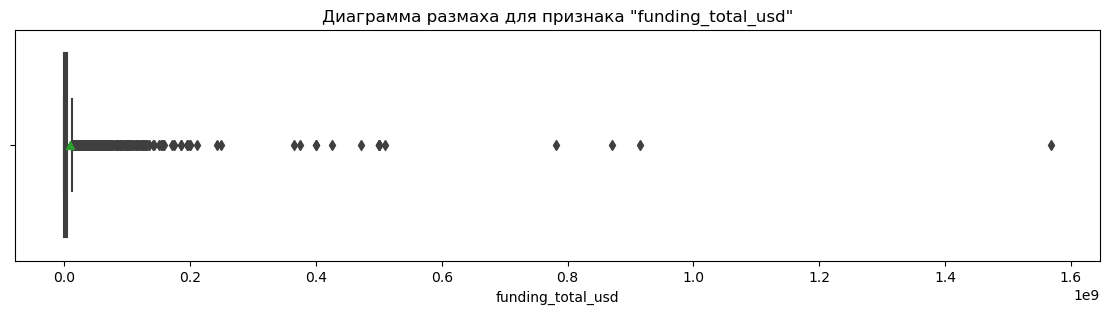

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'funding_total_usd' - до 370000.0.
3. 50% значений 'funding_total_usd' в диапазоне от 370000.0 до 5000000.0.
4. 25% значений 'funding_total_usd' превышают 5000000.0.
5. Медиана 1300000.0
6. Среднее 9203495.11
None
None


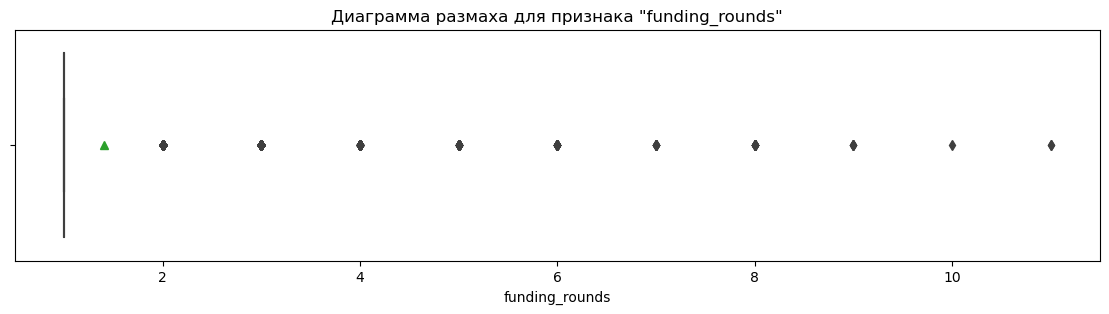

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'funding_rounds' - до 1.0.
3. 50% значений 'funding_rounds' в диапазоне от 1.0 до 1.0.
4. 25% значений 'funding_rounds' превышают 1.0.
5. Медиана 1.0
6. Среднее 1.4
None
None


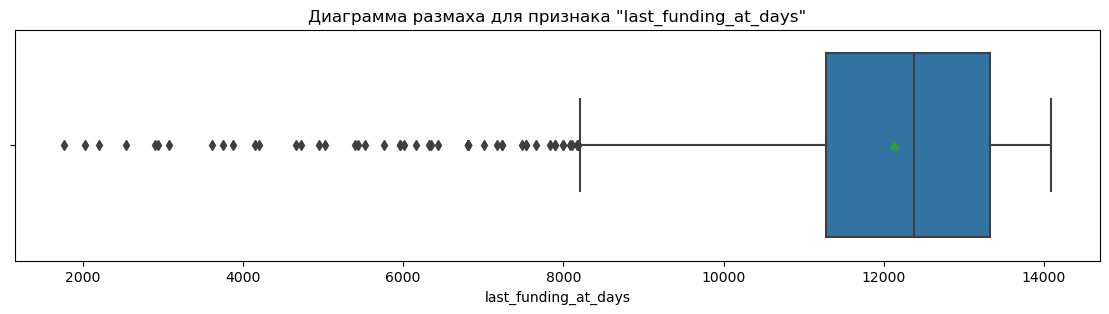

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'last_funding_at_days' - до 11279.0.
3. 50% значений 'last_funding_at_days' в диапазоне от 11279.0 до 13330.0.
4. 25% значений 'last_funding_at_days' превышают 13330.0.
5. Медиана 12374.0
6. Среднее 12124.25
None
None


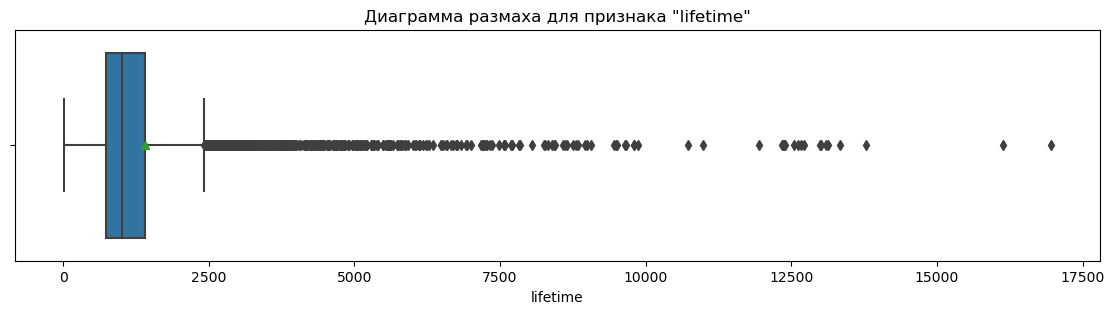

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'lifetime' - до 735.0.
3. 50% значений 'lifetime' в диапазоне от 735.0 до 1410.0.
4. 25% значений 'lifetime' превышают 1410.0.
5. Медиана 1011.0
6. Среднее 1398.58
None
None


In [70]:
# Проведем стат анализ числовых признаков закрывшихся стартапов
num_coll_boxplot(df_kaggle_startups_train_close)

Стат анализ числовых признаков: ['funding_total_usd', 'funding_rounds', 'last_funding_at_days', 'lifetime']


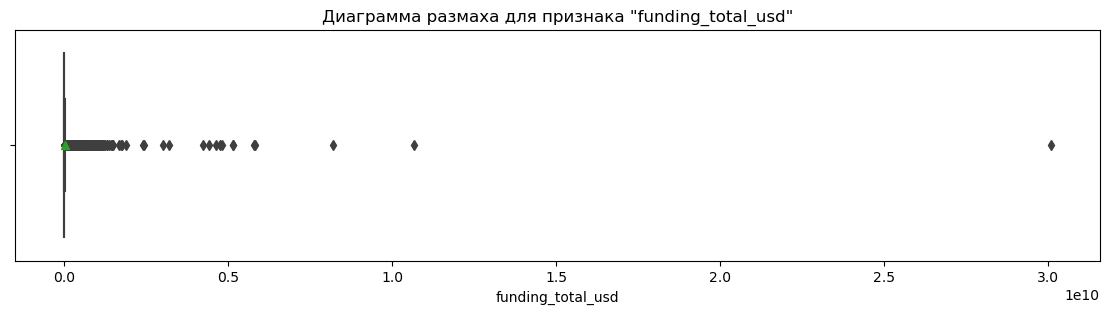

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'funding_total_usd' - до 560000.0.
3. 50% значений 'funding_total_usd' в диапазоне от 560000.0 до 7000000.0.
4. 25% значений 'funding_total_usd' превышают 7000000.0.
5. Медиана 2000000.0
6. Среднее 15730005.81
None
None


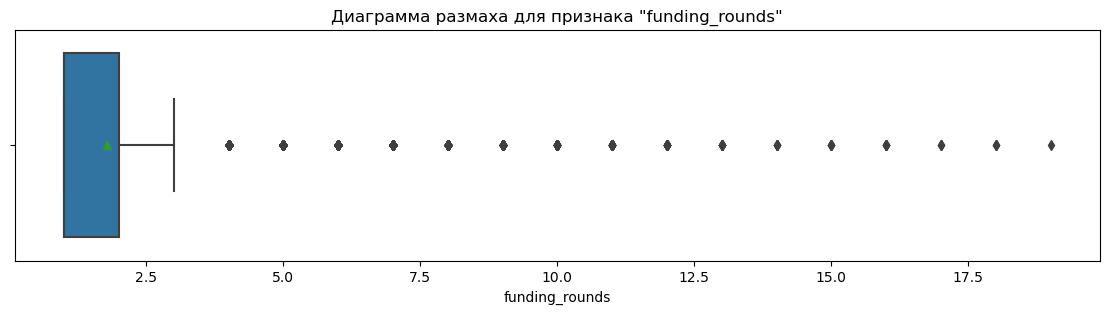

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'funding_rounds' - до 1.0.
3. 50% значений 'funding_rounds' в диапазоне от 1.0 до 2.0.
4. 25% значений 'funding_rounds' превышают 2.0.
5. Медиана 1.0
6. Среднее 1.78
None
None


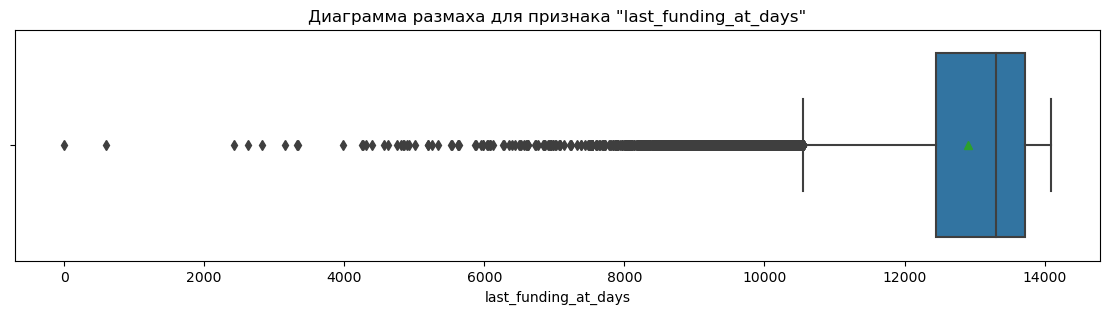

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'last_funding_at_days' - до 12449.0.
3. 50% значений 'last_funding_at_days' в диапазоне от 12449.0 до 13714.0.
4. 25% значений 'last_funding_at_days' превышают 13714.0.
5. Медиана 13303.0
6. Среднее 12900.34
None
None


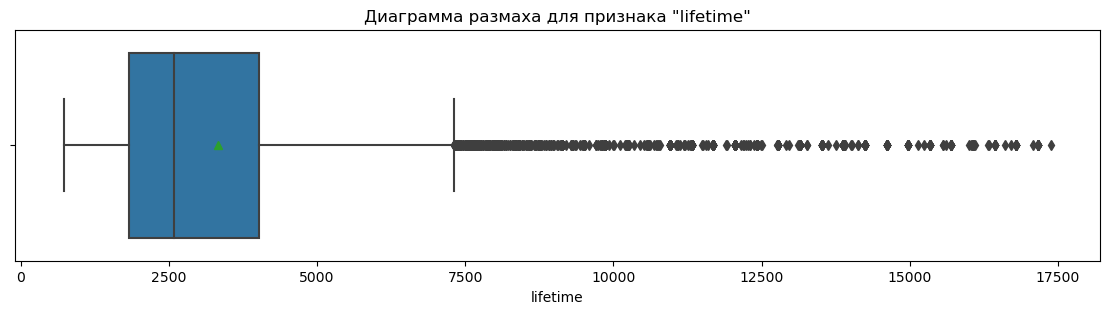

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'lifetime' - до 1826.0.
3. 50% значений 'lifetime' в диапазоне от 1826.0 до 4018.0.
4. 25% значений 'lifetime' превышают 4018.0.
5. Медиана 2577.0
6. Среднее 3320.97
None
None


In [71]:
# Проведем стат анализ числовых признаков действущий стартапов
num_coll_boxplot(df_kaggle_startups_train_open)

Text(0.5, 0, 'Доллары')

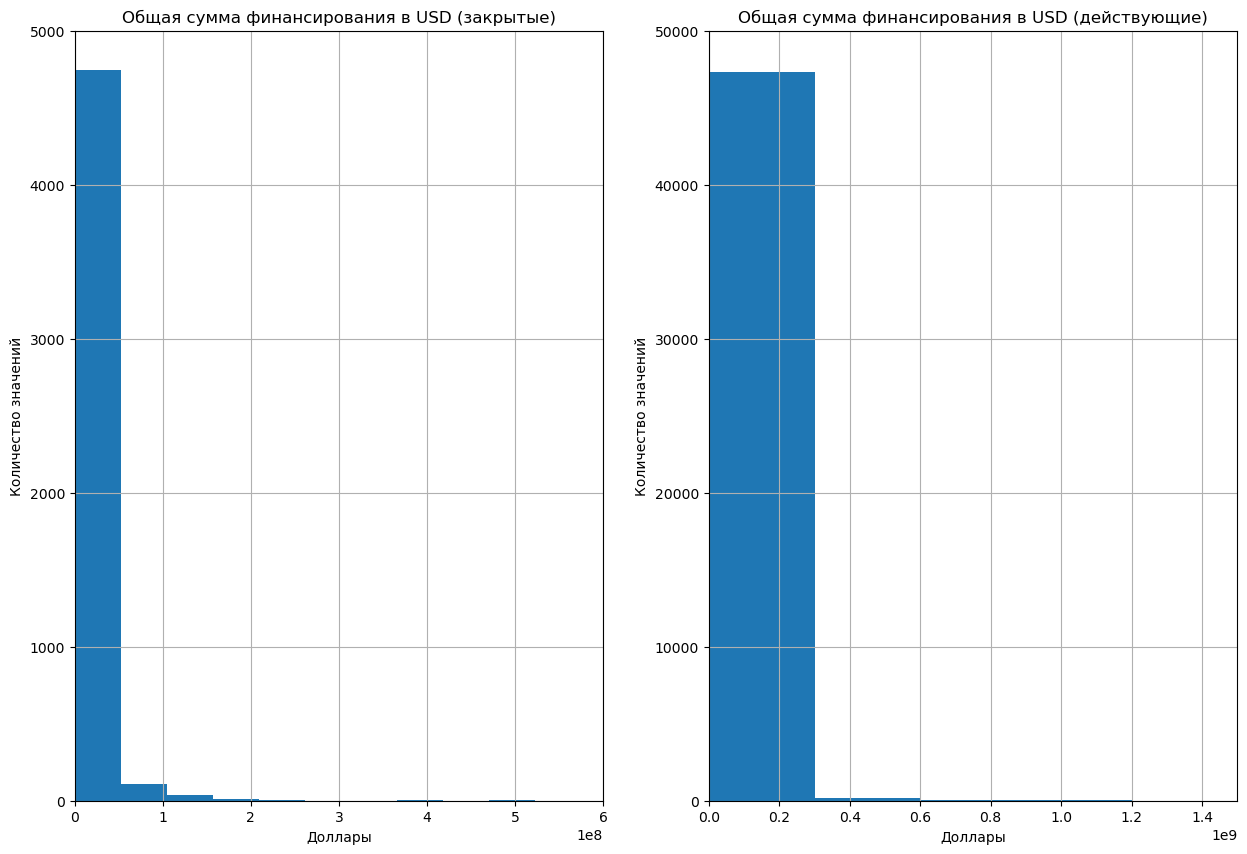

In [72]:
# Сравним распределения по суммам финансирования для закрытых и действующих стартапов. Создаем холст и оси для 2 подграфиков
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# График "сумма финансирования в USD закрытые"
df_kaggle_startups_train_close['funding_total_usd'].plot(kind='hist', grid=True,
bins=30, ylim=(0, 5000), xlim=(0, 600000000), ax=ax[0], legend=False)
ax[0].set_title('Общая сумма финансирования в USD (закрытые)')
ax[0].set_ylabel('Количество значений')
ax[0].set_xlabel('Доллары')

# График "сумма финансирования в USD действующие"
df_kaggle_startups_train_open['funding_total_usd'].plot(kind='hist', grid=True,
bins=100, ylim=(0, 50000), xlim=(0, 1500000000), ax=ax[1], legend=False)
ax[1].set_title('Общая сумма финансирования в USD (действующие)')
ax[1].set_ylabel('Количество значений')
ax[1].set_xlabel('Доллары')

Наблюдаем выраженные ассиметричные правосторонние распределения с длинным правым хвостом, при хвост распределения действующих стартапов значительно длинее (максимальные значения привлеченных инвестиций намного выше по сравнению с закрытыми компаниями)

Text(0.5, 0, 'шт')

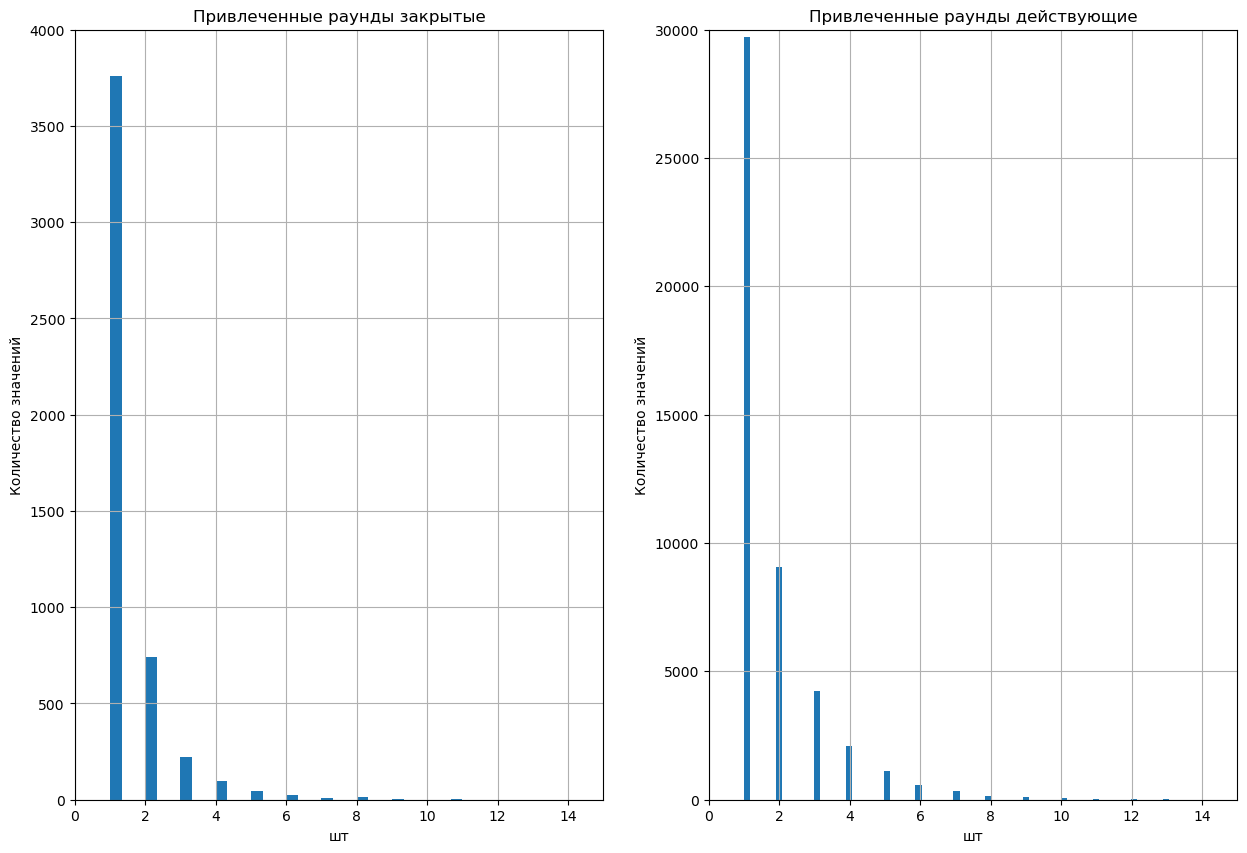

In [73]:
# Сравним распределения по суммам финансирования для закрытых и действующих стартапов. Создаем холст и оси для 2 подграфиков
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# График "сумма финансирования в USD закрытые"
df_kaggle_startups_train_close['funding_rounds'].plot(kind='hist', grid=True,
bins=30, ylim=(0, 4000), xlim=(0, 15), ax=ax[0], legend=False)
ax[0].set_title('Привлеченные раунды закрытые')
ax[0].set_ylabel('Количество значений')
ax[0].set_xlabel('шт')

# График "сумма финансирования в USD действующие"
df_kaggle_startups_train_open['funding_rounds'].plot(kind='hist', grid=True,
bins=100, ylim=(0, 30000), xlim=(0, 15), ax=ax[1], legend=False)
ax[1].set_title('Привлеченные раунды действующие')
ax[1].set_ylabel('Количество значений')
ax[1].set_xlabel('шт')

Text(0.5, 0, 'шт')

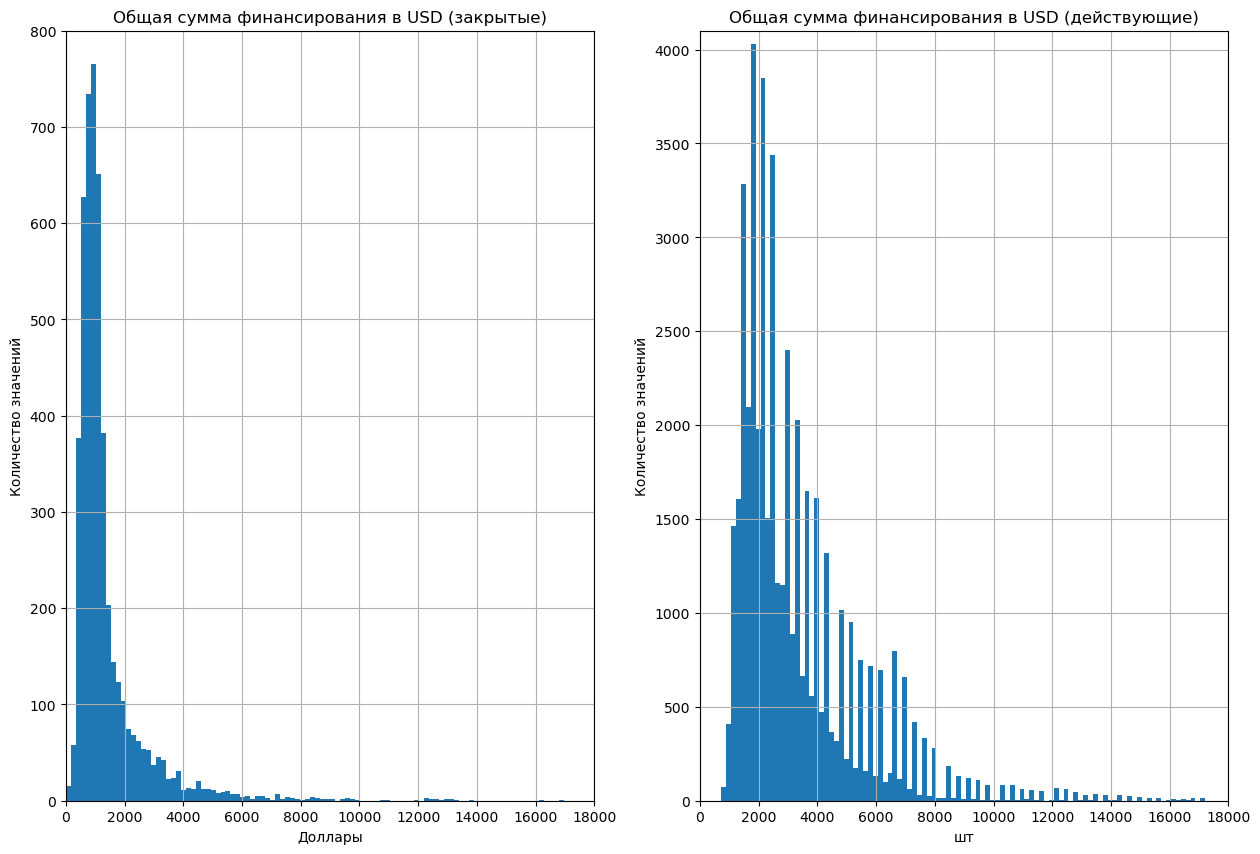

In [74]:
# Сравним распределения по суммам финансирования для закрытых и действующих стартапов. Создаем холст и оси для 2 подграфиков
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# График "сумма финансирования в USD закрытые"
df_kaggle_startups_train_close['lifetime'].plot(kind='hist', grid=True,
bins=100, ylim=(0, 800), xlim=(0, 18000), ax=ax[0], legend=False)
ax[0].set_title('Общая сумма финансирования в USD (закрытые)')
ax[0].set_ylabel('Количество значений')
ax[0].set_xlabel('Доллары')

# График "сумма финансирования в USD действующие"
df_kaggle_startups_train_open['lifetime'].plot(kind='hist', grid=True,
bins=100, ylim=(0, 4100), xlim=(0, 18000), ax=ax[1], legend=False)
ax[1].set_title('Общая сумма финансирования в USD (действующие)')
ax[1].set_ylabel('Количество значений')
ax[1].set_xlabel('шт')

Анализ категориальных признаков проводить нецелесообразно в виду большого числа значений в признаках

Итого по разделу:

Анализ в разрезе целевого признака:

1. funding_total_usd

1.1 funding_total_usd для закрытых
 - Есть значения выходящие за правый дов интервал.
 - 50% значений 'funding_total_usd' в диапазоне от 370000.0 до 5000000.0.
 - Медиана 1300000.0
 - Среднее 9203495.11
 
1.2 funding_total_usd для действующих:
 - Есть значения выходящие за правый дов интервал.
 - 50% значений 'funding_total_usd' в диапазоне от 560000.0 до 7000000.0.
 - Медиана 2000000.0
 - Среднее 15730005.81

2 funding_rounds

2.1. funding_rounds для закрытых
 - Есть значения выходящие за правый дов интервал.
 - 50% значений 'funding_rounds' = 1
 - Медиана 1.0
 - Среднее 1.4
 
2.2. funding_rounds для действующих:
 - Есть значения выходящие за правый дов интервал.
 - 50% значений 'funding_rounds' в диапазоне от 1.0 до 2.0.
 - Медиана 1.0
 - Среднее 1.78

3. last_funding_at_days

3.1. last_funding_at_days для закрытых:
 - 50% значений 'last_funding_at_days' в диапазоне от 11279.0 до 13330.0.
 - Медиана 12374.0
 - Среднее 12124.25
 
3.2. last_funding_at_days для действующих:
 - 50% значений 'last_funding_at_days' в диапазоне от 12449.0 до 13714.0.
 - Медиана 13303.0
 - Среднее 12900.34

4. lifetime

4.1. lifetime для закрытых: 
 - 50% значений 'lifetime' в диапазоне от 735.0 до 1410.0.
 - Медиана 1011.0
 - Среднее 1398.58

4.1. lifetime для действующих:
 - 50% значений 'lifetime' в диапазоне от 1826.0 до 4018.0.
 - Медиана 2577.0
 - Среднее 3320.97


## Фичеинжиниринг

Создадим производные признаки.
Для недопущения утечки целевой переменной исключим комбинации с участием признака found_at, по которым модель сможет определить эту дату. Например, при обучении в качестве входящих признаков, одновременно не используем признаки "Дельта между датой основания и первым привлечением" и "Дельта между первым и последним привлечением в днях" 

In [75]:
# Посчитаем разницу в днях между последним раундом и датой выгрузки
query_date = pd.to_datetime('2018-01-01')

df_kaggle_startups_train['last_funding_current_date'] = (query_date - df_kaggle_startups_train['last_funding_at']).dt.days
df_kaggle_startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date
25929,Forsythe,Consulting|Software,750000.0,operating,USA,IL,Chicago,Skokie,1,1971-01-01,2012-02-09,2012-02-09,2018-01-01,Unspecified,12688,17167,2153


In [76]:
#Посчитаем соотношение между числом дней с последнего рауда и даты выгрузки / life_time
df_kaggle_startups_train['last_funding_lifetime_ratio'] = df_kaggle_startups_train['last_funding_current_date']/df_kaggle_startups_train['lifetime'] 
df_kaggle_startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio
52031,Maxscend Technologies,Manufacturing,11000000.0,operating,CHN,23,Shanghai,Shanghai,2,2006-04-01,2006-10-01,2008-06-01,2018-01-01,Manufacturing,11340,4293,3501,0.815514


In [77]:
# Посчитаем разницу в днях между первым и последним раундом 
df_kaggle_startups_train['delta_last_funding_first_funding'] = (df_kaggle_startups_train['last_funding_at']-df_kaggle_startups_train['first_funding_at']).dt.days
df_kaggle_startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding
37554,SentreHEART,Health Care,26000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2010-09-12,2012-06-04,2012-06-04,2018-01-01,Unspecified,12804,2668,2037,0.763493,0


In [78]:
# Посчитаем средний чек привлечения
df_kaggle_startups_train['mean_check'] = df_kaggle_startups_train['funding_total_usd']/df_kaggle_startups_train['funding_rounds']
df_kaggle_startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding,mean_check
36218,Recensus,E-Commerce,40000.0,operating,GBR,H9,London,London,1,2012-01-19,2012-11-19,2012-11-19,2018-01-01,Unspecified,12972,2174,1869,0.859706,0,40000.0


In [79]:
# Посчитаем количество раундов на 1 год существования
year=365
df_kaggle_startups_train['round_amounts_per_year'] = df_kaggle_startups_train['funding_rounds']/(df_kaggle_startups_train['lifetime']/year)
df_kaggle_startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,last_funding_at,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding,mean_check,round_amounts_per_year
49678,Holimetrix,Electronics,3791818.0,operating,FRA,B9,Lyon,Lyon,1,2014-06-11,...,2015-07-21,2018-01-01,Unspecified,13946,1300,895,0.688462,0,3791818.0,0.280769


In [80]:
# Посчитаем среднюю скорость привлечения денег в день
df_kaggle_startups_train['money_per_day'] = df_kaggle_startups_train['funding_total_usd']/df_kaggle_startups_train['lifetime']
df_kaggle_startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,closed_at,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding,mean_check,round_amounts_per_year,money_per_day
43749,The Product Manufactory,Design|Engineering Firms|Manufacturing,25000.0,operating,USA,IL,"Springfield, Illinois",Urbana,1,2011-08-27,...,2018-01-01,Engineering,12764,2319,2077,0.895645,0,25000.0,0.157395,10.780509


In [81]:
# Посчитаем признак, допускающий утечку Разница между датой основания и первым привлечением.
# Его нельзя использовать вместе с признаком first_funding_at и его производными
df_kaggle_startups_train['founded_at_first_funding'] = (df_kaggle_startups_train['first_funding_at'] - df_kaggle_startups_train['founded_at']).dt.days
df_kaggle_startups_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding,mean_check,round_amounts_per_year,money_per_day,founded_at_first_funding
14190,Contorion,B2B|Industrial|Internet|Marketplaces,2000000.0,operating,DEU,16,Berlin,Berlin,1,2014-01-01,...,Unspecified,13561,1461,1280,0.876112,0,2000000.0,0.249829,1368.925394,181


In [82]:
check_df(df_kaggle_startups_train)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   name                              52514 non-null  object        
 1   category_list                     52514 non-null  object        
 2   funding_total_usd                 52514 non-null  float64       
 3   status                            52514 non-null  object        
 4   country_code                      52514 non-null  object        
 5   state_code                        45752 non-null  object        
 6   region                            46156 non-null  object        
 7   city                              46156 non-null  object        
 8   funding_rounds                    52514 non-null  int64         
 9   founded_at                        52514 non-null  datetime64[ns]
 10  first_funding_at                  

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,yc_category,last_funding_at_days,lifetime,last_funding_current_date,last_funding_lifetime_ratio,delta_last_funding_first_funding,mean_check,round_amounts_per_year,money_per_day,founded_at_first_funding
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,...,Unspecified,13714,2923,1127,0.385563,1310,4.143130e+05,0.249743,283.484776,486
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,Medical Devices,13435,4748,1406,0.296125,1393,1.073375e+07,0.307498,9042.758846,1949
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,Unspecified,13562,4383,1279,0.291809,681,1.181879e+07,0.249829,8089.523386,2423
3,Sancilio and Company,Health Care,22250000.0,operating,USA,NaN,NaN,NaN,3,2004-01-01,...,Unspecified,13578,5114,1263,0.246969,1051,7.416667e+06,0.214118,4350.801721,2800
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,...,Manufacturing,12680,2650,2161,0.815472,0,2.000000e+06,0.137736,754.716981,489


### Итого по разделу:

    Разработаны новые синтетические признаки
     - разница в днях между последним раундом и датой выгрузки
     - соотношение между числом дней с последнего рауда и даты выгрузки / life_time
     - разница в днях между первым и последним раундом
     - средний чек привлечения
     - количество раундов на 1 год существования
     - средняя скорость привлечения денег в день
     - Разница между датой основания и первым привлечением. Признак, допускающий утечку (не используется в обучении).

## Корреляционный анализ признаков

#### Расчет коэффициентов корреляции между признаками

In [83]:
num_coll_list =  df_kaggle_startups_train.select_dtypes(include='number').columns.tolist()

Text(0.5, 1.0, 'Тепловая карта корреляции Пирсона')

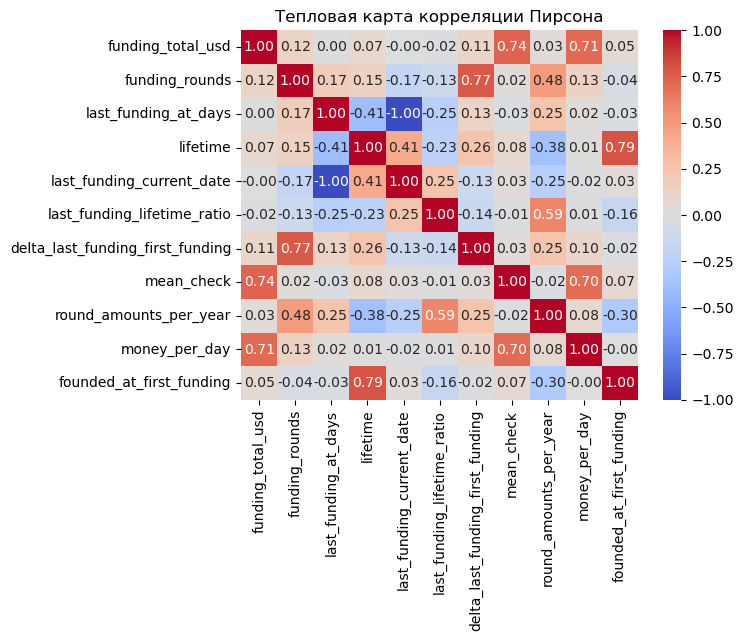

In [84]:
#Построим heatmap с корреляцией признаков
sns.heatmap(df_kaggle_startups_train[num_coll_list].corr(), annot=True, cmap='coolwarm', fmt=".2f") 
plt.title('Тепловая карта корреляции Пирсона')

Корреляция и мультиколлинеарность между числовыми признаками отсутстует. В виду того, что на прошлом шаге мы обнаружили выбивающиеся значения оценим корреляцию Спирмана.

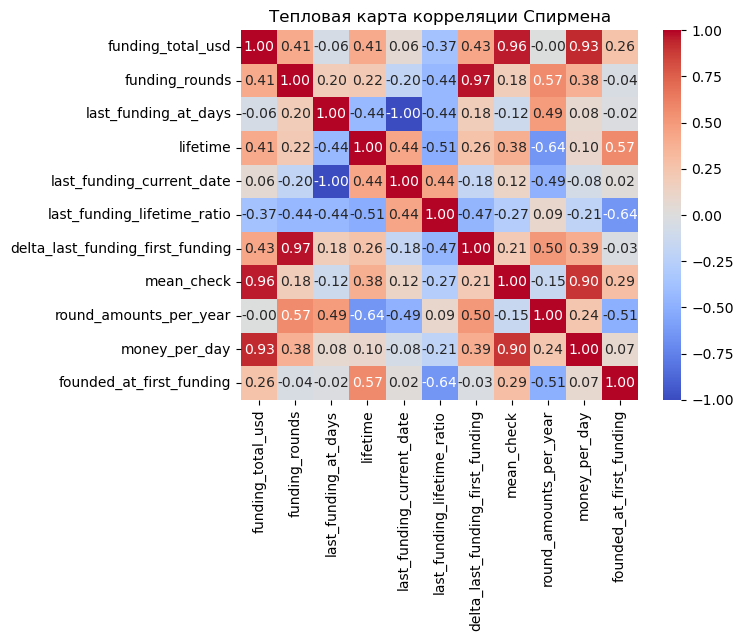

In [85]:
# Построим heatmap с корреляцией Спирмена 
sns.heatmap(df_kaggle_startups_train[num_coll_list].corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции Спирмена')
plt.show()

Наблюдаем мультиколлинеарность между сл. признаками:
- funding_total_usd и mean_check
- funding_rounds и delta_last_funding_first_funding

Подготовим к датасет к поиску корреляций всех доступных признаков

In [86]:
df_kaggle_startups_train['country_code'].nunique()

134

In [87]:
# Соберем выборку из 500 записей, для ускорения построения матрицы Фи. Сохраним пропорцию значений целевого признака
df_kaggle_startups_train_small, _ = train_test_split(
    df_kaggle_startups_train,
    train_size=500,
    stratify=df_kaggle_startups_train['status'],
    random_state=42
)

In [88]:
df_kaggle_startups_train_small=df_kaggle_startups_train_small.drop('name', axis=1)
df_kaggle_startups_train_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 50066 to 1806
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   category_list                     500 non-null    object        
 1   funding_total_usd                 500 non-null    float64       
 2   status                            500 non-null    object        
 3   country_code                      500 non-null    object        
 4   state_code                        428 non-null    object        
 5   region                            438 non-null    object        
 6   city                              438 non-null    object        
 7   funding_rounds                    500 non-null    int64         
 8   founded_at                        500 non-null    datetime64[ns]
 9   first_funding_at                  500 non-null    datetime64[ns]
 10  last_funding_at                   500 non-null    

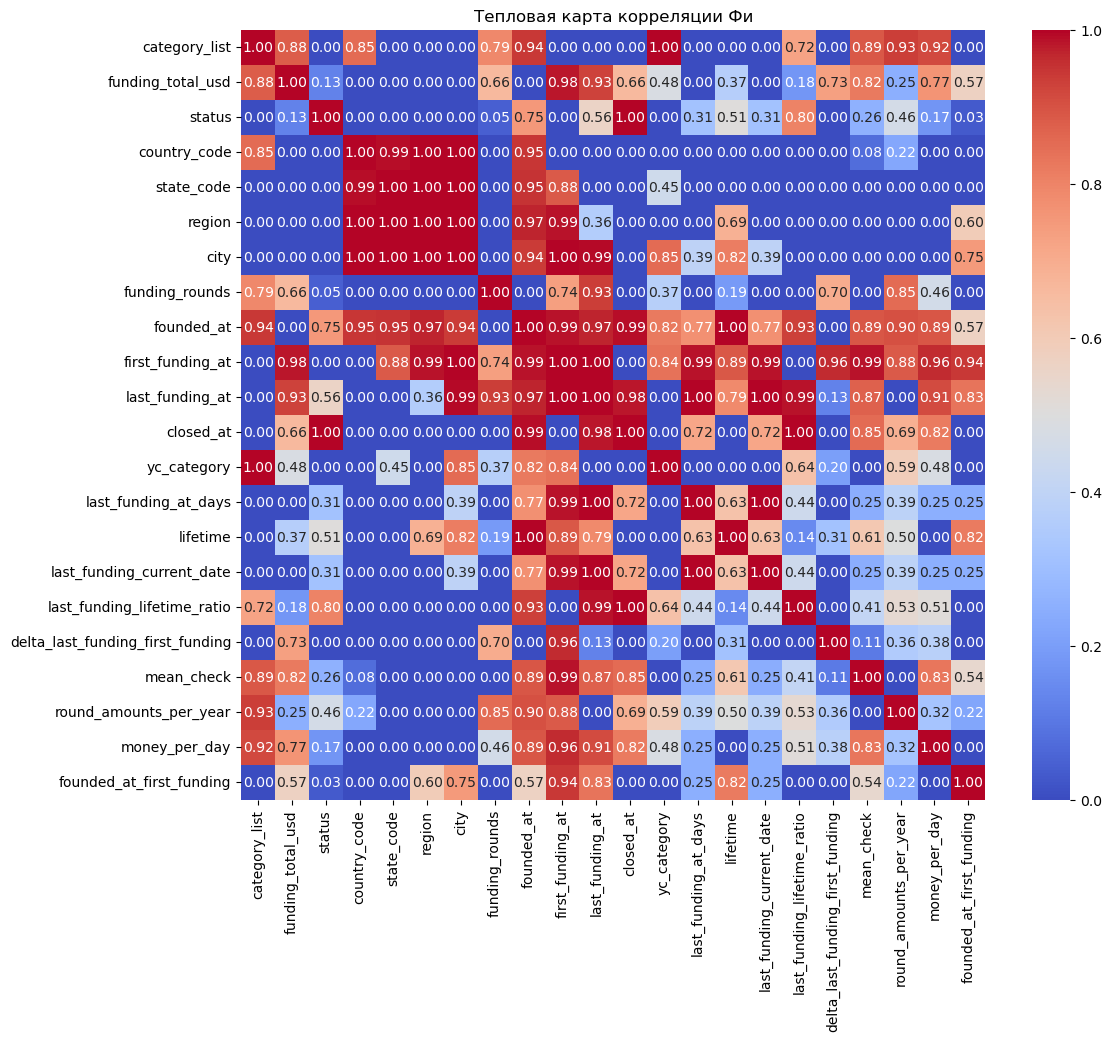

In [89]:
#Построим матрицу корреции Фи для анализа корреляции в том числе категориальных признаков на целевой
phik_matrix=df_kaggle_startups_train_small.phik_matrix(interval_cols=num_coll_list)
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции Фи')
plt.show()

### Выводы по итогам раздела:
- мультиколлинеарность между признаками state_code, country_code, city, region (корреляция = 1). Целесообразно оставить в качестве входящего признак с наименьним числом уникальных значений (country_code) и наименьшим количеством пропусков, удалим 2 оставшихся.
- мультиколлинеарность между признаками first_funding_at_days и last_funding_at. Целесообразно last_funding_at оставить в качестве входящего признака с  наибольшей корреляей с целевым 
- мультиколлинеарность между признаками last_funding_at_days и last_funding_current_date. Целесообразно last_funding_at_days оставить в качестве входящего признака с  наибольшей корреляей с целевым.
- устойчивую корреляцию целевого признака с производным признаком last_funding_lifetime_ration (0.75). 
- умеренную корреляцию целевого признака с признаком lifetime (Фи 0,5), last_funding_at(0,59), founded_at (0,5)

## Отбор финального набора обучающих признаков

По итогам предыдущего раздела удалим из из датасетов следующие столбцы:

    - name - ключ
	- state_code - мультиколлинеарный признак  
	- city - мультиколлинеарный признак 
    - region - мультиколлинеарный признак 
	- founded_at - во избежание утечки целевой переменной
	- closed_at - отсутствует в тестовой выборке
	- category_list - заменили на yc_category в виду большого числа уникальных значений 
    - first_funding_at -мультиколлинеарный признак
    - last_funding_at, его  заменили на last_funding_at_days
    - mean_check - мультиколлинеарный признак с funding_total_usd
    - delta_last_funding_first_funding мультиколлинеарный признак с funding_rounds и last_funding_at_days в сочетании с founded_at_first_funding дает утечку целевой переменной.
    - last_funding_current_date  мультиколлинеарный признак с last_funding_at_days
    - founded_at_first_funding мультиколлинеарный признак с last_funding_current_date?


In [90]:
columns_to_drop = ['name', 'state_code', 'city', 'region', 'founded_at', 'closed_at', 'category_list', 'first_funding_at', 'last_funding_at', 'mean_check', 'delta_last_funding_first_funding', 'last_funding_current_date', 'founded_at_first_funding']

In [91]:
df_kaggle_startups_train_pipe = df_kaggle_startups_train.drop(columns_to_drop, axis=1)

In [92]:
# Закодируем целевой признак 
def y_to_binary(i): 
    if i=='closed':
        return 1
    else:
        return 0

In [93]:
#Применим функцию для преобразования целевого признака в числовой
df_kaggle_startups_train_pipe['status'] = df_kaggle_startups_train_pipe['status'].apply(y_to_binary) 

In [94]:
df_kaggle_startups_train_pipe.sample(10)

,funding_total_usd,status,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
51608,25000.0,0,USA,1,Analytics,13500,1572,0.853053,0.232188,15.903308
50563,40000.0,0,BRA,1,Unspecified,12266,2913,0.883968,0.125300,13.731548
31279,40000.0,0,USA,1,Marketing,12870,2138,0.921890,0.170720,18.709074
18385,2000000.0,0,BRA,1,Unspecified,12863,1979,0.999495,0.184437,1010.611420
49158,13537704.0,0,USA,2,Design,13283,6356,0.245123,0.114852,2129.909377
44156,855620.0,0,USA,1,Unspecified,12951,5844,0.323409,0.062457,146.409993
10946,510142.0,0,GBR,1,Unspecified,13672,1859,0.628833,0.196342,274.417429
933,1080000.0,0,USA,1,Finance,13620,1269,0.962175,0.287628,851.063830
25090,2000000.0,0,USA,1,Design,13439,1696,0.826651,0.215212,1179.245283
27169,17136.0,1,DEU,1,Unspecified,13880,666,1.442943,0.548048,25.729730


In [95]:
# Еще раз посмотрим на матрицу Фи с учетом удаленных признаков
# Соберем выборку из 1000 записей, для ускорения построения матрицы Фи. Сохраним пропорцию значений целевого признака
df_kaggle_startups_train_small, _ = train_test_split(
    df_kaggle_startups_train_pipe,
    train_size=1000,
    stratify=df_kaggle_startups_train_pipe['status'],
    random_state=42
)

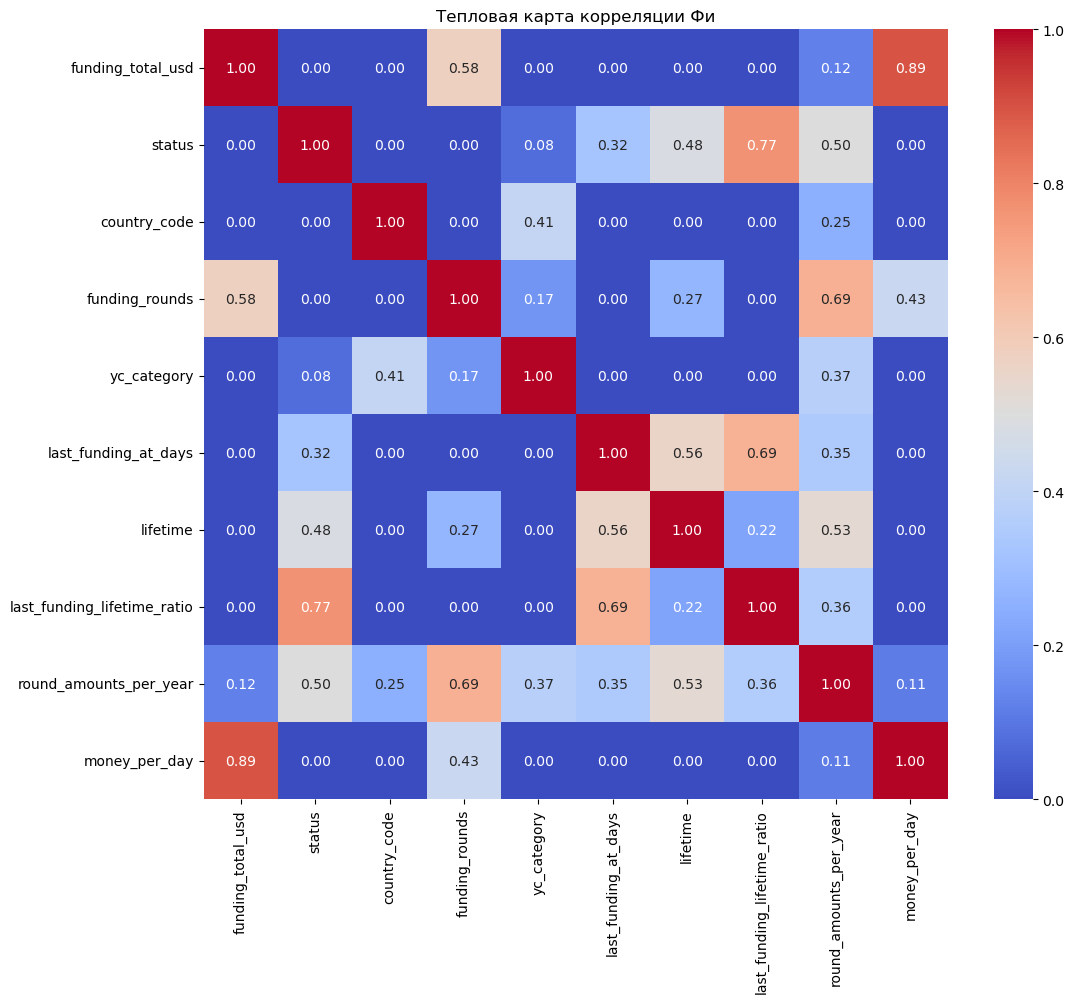

In [96]:
#Построим матрицу корреции Фи для анализа корреляции в том числе категориальных признаков на целевой
phik_matrix=df_kaggle_startups_train_small.phik_matrix(interval_cols=num_coll_list)
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции Фи')
plt.show()

In [97]:
check_df(df_kaggle_startups_train_pipe)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   funding_total_usd            52514 non-null  float64
 1   status                       52514 non-null  int64  
 2   country_code                 52514 non-null  object 
 3   funding_rounds               52514 non-null  int64  
 4   yc_category                  52514 non-null  object 
 5   last_funding_at_days         52514 non-null  int64  
 6   lifetime                     52514 non-null  int64  
 7   last_funding_lifetime_ratio  52514 non-null  float64
 8   round_amounts_per_year       52514 non-null  float64
 9   money_per_day                52514 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 4.0+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
В датафре

,funding_total_usd,status,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
0,828626.0,0,CHE,2,Unspecified,13714,2923,0.385563,0.249743,283.484776
1,42935019.0,0,USA,4,Medical Devices,13435,4748,0.296125,0.307498,9042.758846
2,35456381.0,0,USA,3,Unspecified,13562,4383,0.291809,0.249829,8089.523386
3,22250000.0,0,USA,3,Unspecified,13578,5114,0.246969,0.214118,4350.801721
4,2000000.0,0,USA,1,Manufacturing,12680,2650,0.815472,0.137736,754.716981


In [98]:
#Удалим образовавшиеся явные дубликаты
df_kaggle_startups_train_pipe = df_kaggle_startups_train_pipe.drop_duplicates()
check_df(df_kaggle_startups_train_pipe)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
Index: 52313 entries, 0 to 52513
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   funding_total_usd            52313 non-null  float64
 1   status                       52313 non-null  int64  
 2   country_code                 52313 non-null  object 
 3   funding_rounds               52313 non-null  int64  
 4   yc_category                  52313 non-null  object 
 5   last_funding_at_days         52313 non-null  int64  
 6   lifetime                     52313 non-null  int64  
 7   last_funding_lifetime_ratio  52313 non-null  float64
 8   round_amounts_per_year       52313 non-null  float64
 9   money_per_day                52313 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 4.4+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликат

,funding_total_usd,status,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
0,828626.0,0,CHE,2,Unspecified,13714,2923,0.385563,0.249743,283.484776
1,42935019.0,0,USA,4,Medical Devices,13435,4748,0.296125,0.307498,9042.758846
2,35456381.0,0,USA,3,Unspecified,13562,4383,0.291809,0.249829,8089.523386
3,22250000.0,0,USA,3,Unspecified,13578,5114,0.246969,0.214118,4350.801721
4,2000000.0,0,USA,1,Manufacturing,12680,2650,0.815472,0.137736,754.716981


In [99]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_kaggle_startups_train_pipe.drop('status', axis=1),
    df_kaggle_startups_train_pipe['status'],
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=df_kaggle_startups_train_pipe['status']
)

In [100]:
print(X_train.isnull().sum())
print(y_train.isnull().sum())

funding_total_usd              0
country_code                   0
funding_rounds                 0
yc_category                    0
last_funding_at_days           0
lifetime                       0
last_funding_lifetime_ratio    0
round_amounts_per_year         0
money_per_day                  0
dtype: int64
0


In [101]:
num_columns=['funding_total_usd',
             'funding_rounds',
             'lifetime',
             'last_funding_at_days',
             'last_funding_lifetime_ratio', 'money_per_day', 'round_amounts_per_year'
            ]
ohe_columns=['country_code', 'yc_category']

In [102]:

# SimpleImputer + OHE
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('simpleImputer_num', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),  # Место для гиперпараметров StandardScaler, MinMaxScaler, RobustScaler
])

# Предобработка данных
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', StandardScaler(), num_columns)
], remainder='passthrough')

# Итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Гиперпараметры для поиска
param_distributions = {
    'model__max_iter': IntDistribution(50, 200),
    'model__learning_rate': FloatDistribution(0.01, 0.2),
    'model__max_depth': IntDistribution(2, 10),
    'model__min_samples_leaf': IntDistribution(1, 20),
    'model__l2_regularization': FloatDistribution(0.0, 1.0),
    'preprocessor__num': optuna.distributions.CategoricalDistribution([
        StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'
    ])
}

In [103]:
optuna_search = OptunaSearchCV(
    estimator=pipe_final,
    param_distributions=param_distributions,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_trials=200  
)

optuna_search.fit(X_train, y_train)

[I 2024-06-16 17:21:59,670] A new study created in memory with name: no-name-cf467b4b-d1ef-40d6-bb46-fc29f9a23ab3
  File "C:\Users\fidel\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
  File "C:\Users\fidel\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
  File "C:\Users\fidel\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
  File "C:\Users\fidel\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
[I 2024-06-16 17:22:32,802] Trial 2 finished with value: 0.8791515018734909 and parameters: {'model__max_iter': 62, 'model__learning_rate': 0.16758501788022093, 'model__max_depth': 3, 'model__min_samples_leaf': 7, 'model__l2_regularization': 0.8796645084574759, 'preprocessor__num':

[I 2024-06-16 17:26:18,320] Trial 20 finished with value: 0.8866259641170844 and parameters: {'model__max_iter': 114, 'model__learning_rate': 0.10136642111178043, 'model__max_depth': 9, 'model__min_samples_leaf': 9, 'model__l2_regularization': 0.15031589164590997, 'preprocessor__num': MinMaxScaler()}. Best is trial 6 with value: 0.8873477366533915.
[I 2024-06-16 17:26:24,015] Trial 30 finished with value: 0.8865314562902926 and parameters: {'model__max_iter': 127, 'model__learning_rate': 0.19846000133715164, 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__l2_regularization': 0.5498453027467738, 'preprocessor__num': MinMaxScaler()}. Best is trial 6 with value: 0.8873477366533915.
[I 2024-06-16 17:26:31,143] Trial 28 finished with value: 0.8865144042549723 and parameters: {'model__max_iter': 123, 'model__learning_rate': 0.19766832453042146, 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__l2_regularization': 0.5823585345665605, 'preprocessor__num': MinMaxScal

[I 2024-06-16 17:29:48,081] Trial 47 finished with value: 0.8873582580715785 and parameters: {'model__max_iter': 147, 'model__learning_rate': 0.1780583022472987, 'model__max_depth': 9, 'model__min_samples_leaf': 1, 'model__l2_regularization': 0.6829999621858608, 'preprocessor__num': 'passthrough'}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:29:52,084] Trial 40 finished with value: 0.8866357131570378 and parameters: {'model__max_iter': 147, 'model__learning_rate': 0.12298035664886225, 'model__max_depth': 9, 'model__min_samples_leaf': 17, 'model__l2_regularization': 0.4981348046864684, 'preprocessor__num': RobustScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:29:52,512] Trial 50 finished with value: 0.8883120486015222 and parameters: {'model__max_iter': 145, 'model__learning_rate': 0.17979724714270928, 'model__max_depth': 9, 'model__min_samples_leaf': 17, 'model__l2_regularization': 0.6732883180302939, 'preprocessor__num': MinMaxScaler(

[I 2024-06-16 17:33:48,121] Trial 71 finished with value: 0.8865434415285038 and parameters: {'model__max_iter': 171, 'model__learning_rate': 0.15824942030437017, 'model__max_depth': 8, 'model__min_samples_leaf': 14, 'model__l2_regularization': 0.9300349817880187, 'preprocessor__num': RobustScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:33:50,138] Trial 70 finished with value: 0.8864831406824176 and parameters: {'model__max_iter': 135, 'model__learning_rate': 0.15974337110455922, 'model__max_depth': 8, 'model__min_samples_leaf': 14, 'model__l2_regularization': 0.9195751680994673, 'preprocessor__num': RobustScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:34:32,416] Trial 72 finished with value: 0.8883303530882763 and parameters: {'model__max_iter': 168, 'model__learning_rate': 0.15592184216078803, 'model__max_depth': 8, 'model__min_samples_leaf': 15, 'model__l2_regularization': 0.9350110271142686, 'preprocessor__num': RobustScal

[I 2024-06-16 17:37:30,021] Trial 94 finished with value: 0.8869915912805982 and parameters: {'model__max_iter': 152, 'model__learning_rate': 0.18559560746940357, 'model__max_depth': 7, 'model__min_samples_leaf': 12, 'model__l2_regularization': 0.882915023594217, 'preprocessor__num': StandardScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:37:43,511] Trial 99 finished with value: 0.888564246281538 and parameters: {'model__max_iter': 130, 'model__learning_rate': 0.16829605629028585, 'model__max_depth': 7, 'model__min_samples_leaf': 19, 'model__l2_regularization': 0.8990544420027786, 'preprocessor__num': RobustScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:37:47,255] Trial 93 finished with value: 0.8883667570693264 and parameters: {'model__max_iter': 155, 'model__learning_rate': 0.1473237127441124, 'model__max_depth': 7, 'model__min_samples_leaf': 12, 'model__l2_regularization': 0.8812345734813272, 'preprocessor__num': RobustScale

[I 2024-06-16 17:41:57,525] Trial 118 finished with value: 0.8885604288364325 and parameters: {'model__max_iter': 117, 'model__learning_rate': 0.13811942291002843, 'model__max_depth': 9, 'model__min_samples_leaf': 13, 'model__l2_regularization': 0.9687691984336064, 'preprocessor__num': RobustScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:42:00,207] Trial 120 finished with value: 0.888439764545641 and parameters: {'model__max_iter': 121, 'model__learning_rate': 0.18315944582446983, 'model__max_depth': 9, 'model__min_samples_leaf': 13, 'model__l2_regularization': 0.9582447687629067, 'preprocessor__num': RobustScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:42:16,982] Trial 121 finished with value: 0.8886967553086554 and parameters: {'model__max_iter': 120, 'model__learning_rate': 0.164285294341198, 'model__max_depth': 9, 'model__min_samples_leaf': 13, 'model__l2_regularization': 0.9760828749599935, 'preprocessor__num': RobustScal

[I 2024-06-16 17:45:36,550] Trial 141 finished with value: 0.8874999838256766 and parameters: {'model__max_iter': 111, 'model__learning_rate': 0.1644979578427903, 'model__max_depth': 10, 'model__min_samples_leaf': 15, 'model__l2_regularization': 0.989554232587307, 'preprocessor__num': RobustScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:45:51,013] Trial 142 finished with value: 0.8885475717996979 and parameters: {'model__max_iter': 112, 'model__learning_rate': 0.16387307271509502, 'model__max_depth': 10, 'model__min_samples_leaf': 15, 'model__l2_regularization': 0.9942756495898658, 'preprocessor__num': RobustScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:45:56,768] Trial 146 finished with value: 0.8889359511571449 and parameters: {'model__max_iter': 177, 'model__learning_rate': 0.16535078623720056, 'model__max_depth': 10, 'model__min_samples_leaf': 15, 'model__l2_regularization': 0.9999510345850608, 'preprocessor__num': Robust

[I 2024-06-16 17:48:56,215] Trial 168 finished with value: 0.8869230243403756 and parameters: {'model__max_iter': 96, 'model__learning_rate': 0.1975554813907573, 'model__max_depth': 10, 'model__min_samples_leaf': 18, 'model__l2_regularization': 0.20243330834142115, 'preprocessor__num': 'passthrough'}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:49:23,658] Trial 167 finished with value: 0.8861634788240202 and parameters: {'model__max_iter': 100, 'model__learning_rate': 0.1919874561651623, 'model__max_depth': 10, 'model__min_samples_leaf': 18, 'model__l2_regularization': 0.5939718149429131, 'preprocessor__num': 'passthrough'}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:49:26,279] Trial 166 finished with value: 0.8880808447912036 and parameters: {'model__max_iter': 143, 'model__learning_rate': 0.17663467740543093, 'model__max_depth': 10, 'model__min_samples_leaf': 18, 'model__l2_regularization': 0.5940776571534832, 'preprocessor__num': 'passthr

[I 2024-06-16 17:53:03,665] Trial 195 finished with value: 0.8862558137207923 and parameters: {'model__max_iter': 137, 'model__learning_rate': 0.18575004598044434, 'model__max_depth': 9, 'model__min_samples_leaf': 17, 'model__l2_regularization': 0.02977710942559475, 'preprocessor__num': RobustScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:53:03,953] Trial 193 finished with value: 0.8865854715433616 and parameters: {'model__max_iter': 176, 'model__learning_rate': 0.19898534222253453, 'model__max_depth': 9, 'model__min_samples_leaf': 17, 'model__l2_regularization': 0.49382049598866823, 'preprocessor__num': RobustScaler()}. Best is trial 42 with value: 0.8909350395866176.
[I 2024-06-16 17:53:08,424] Trial 192 finished with value: 0.8873509094621781 and parameters: {'model__max_iter': 177, 'model__learning_rate': 0.18395812477941295, 'model__max_depth': 9, 'model__min_samples_leaf': 17, 'model__l2_regularization': 0.948430574161614, 'preprocessor__num': Robust

OptunaSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse=False))]),
                                                                           ['country_code',
                                                                            '...
                                    'model__max_depth': IntDistribution(high=10, log=False, low=2, step=1),
                                    'model__max_iter': IntDistribution(high=200, log=False, low=50, step=1),
                                    'model__min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1),
                                    'preprocessor__num': CategoricalDistribution(choices=(StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'))},
               random_state=42, scoring='f1')

In [104]:
print('Лучшая модель и её параметры:\n\n', optuna_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['country_code',
                                                   'yc_category']),
                                                 ('num', RobustScaler(),
                                       

In [105]:
print('Метрика f1 для лучшей модели:\n', optuna_search.best_score_)

Метрика f1 для лучшей модели:
 0.8909350395866176


In [106]:
y_test_pred = optuna_search.predict(X_test)
print(f'Метрика f1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Метрика f1 на тестовой выборке: 0.8820200261210275


In [107]:
pd.DataFrame(optuna_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
0,22.944520,1.010542,0.260639,0.029699,0.888087,0.872464,0.888889,0.883687,0.882438,0.883113,0.005870
1,20.736893,5.109800,0.341025,0.073887,0.892396,0.876990,0.886131,0.883857,0.881109,0.884097,0.005148
2,6.385049,0.864999,0.222272,0.038908,0.885798,0.868672,0.882698,0.882483,0.876106,0.879152,0.006115
3,13.577787,3.192344,0.349067,0.060826,0.889855,0.878084,0.889213,0.886613,0.880411,0.884835,0.004747
4,22.697187,1.102470,0.258444,0.057206,0.896996,0.877345,0.890182,0.885485,0.884058,0.886813,0.006543
...,...,...,...,...,...,...,...,...,...,...,...
195,21.262822,6.461958,0.257903,0.094696,0.894437,0.871942,0.889211,0.889211,0.886479,0.886256,0.007607
196,28.518765,18.042178,0.237925,0.156595,0.890332,0.877522,0.886628,0.878832,0.886314,0.883926,0.004919
197,18.915291,7.952637,0.191443,0.084517,0.895908,0.878679,0.889211,0.889855,0.891304,0.888991,0.005663
198,18.448743,6.053284,0.216140,0.070254,0.894925,0.875629,0.892909,0.886643,0.888406,0.887702,0.006733


## Формирование предсказаний на тестовом датасете

In [108]:
# Приведем тестовый датасет в соответствие с тренировочным
df_kaggle_startups_test.sample()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days
1136,Snapsort,Advice|Artificial Intelligence|Automotive|Cura...,500000.0,CAN,ON,Toronto,Waterloo,1,2009-08-01,2011-08-19,2011-08-19,3075,Automotive,14005


In [109]:
# добавим недостающие столбцы
# Посчитаем разницу в днях между последним раундом и датой выгрузки
df_kaggle_startups_test['last_funding_current_date'] = (query_date - df_kaggle_startups_test['last_funding_at']).dt.days
df_kaggle_startups_test.sample()


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days,last_funding_current_date
7175,YADOX,E-Commerce|Retail,2000000.0,USA,FL,Miami,Miami,1,2015-05-20,2015-08-28,2015-08-28,957,Retail,15475,857


In [110]:
#Посчитаем соотношение между числом дней с последнего рауда и даты выгрузки / life_time
df_kaggle_startups_test['last_funding_lifetime_ratio'] = df_kaggle_startups_test['last_funding_current_date']/df_kaggle_startups_test['lifetime'] 
df_kaggle_startups_test.sample()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days,last_funding_current_date,last_funding_lifetime_ratio
3676,Znapshop,E-Commerce|Mobile Commerce,50000.0,USA,NaN,NaN,NaN,1,2011-04-18,2011-04-01,2011-04-01,634,Unspecified,13865,2467,3.891167


In [111]:
# Посчитаем количество раундов на 1 год существования
df_kaggle_startups_test['round_amounts_per_year'] = df_kaggle_startups_test['funding_rounds']/(df_kaggle_startups_test['lifetime']/year)
df_kaggle_startups_test.sample()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days,last_funding_current_date,last_funding_lifetime_ratio,round_amounts_per_year
13061,Quikr,Curated Web,346000000.0,IND,16,Mumbai,Mumbai,6,2008-01-12,2010-03-31,2015-04-07,3642,Unspecified,15332,1000,0.274574,0.601318


In [112]:
# Посчитаем среднюю скорость привлечения денег в день
df_kaggle_startups_test['money_per_day'] = df_kaggle_startups_test['funding_total_usd']/df_kaggle_startups_test['lifetime']
df_kaggle_startups_test.sample()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days,last_funding_current_date,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
2159,C2 Therapeutics,Biotechnology,20384582.0,USA,CA,SF Bay Area,Redwood City,5,2007-01-01,2009-06-16,2015-06-18,4018,Unspecified,15404,928,0.230961,0.454206,5073.31558


In [113]:
# Посчитаем признак, допускающий утечку Разница между датой основания и первым привлечением.
# Его нельзя использовать вместе с признаком first_funding_at и его производными
df_kaggle_startups_test['founded_at_first_funding'] = (df_kaggle_startups_test['first_funding_at'] - df_kaggle_startups_test['founded_at']).dt.days
df_kaggle_startups_test.sample()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,yc_category,last_funding_at_days,last_funding_current_date,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day,founded_at_first_funding
6416,MakersTV,Startups,2000000.0,IRL,7,Dublin,Dublin,1,2013-05-11,2014-07-01,2014-07-01,1696,Unspecified,15052,1280,0.754717,0.215212,1179.245283,416


In [114]:
df_kaggle_startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   name                         13125 non-null  object        
 1   category_list                13125 non-null  object        
 2   funding_total_usd            13125 non-null  float64       
 3   country_code                 13125 non-null  object        
 4   state_code                   11430 non-null  object        
 5   region                       11536 non-null  object        
 6   city                         11538 non-null  object        
 7   funding_rounds               13125 non-null  int64         
 8   founded_at                   13125 non-null  datetime64[ns]
 9   first_funding_at             13125 non-null  datetime64[ns]
 10  last_funding_at              13125 non-null  datetime64[ns]
 11  lifetime                     13125 non-nu

 0   funding_total_usd            52313 non-null  float64
 1   status                       52313 non-null  int64  
 2   country_code                 52313 non-null  object 
 3   funding_rounds               52313 non-null  int64  
 4   yc_category                  52313 non-null  object 
 5   last_funding_at_days         52313 non-null  int64  
 6   lifetime                     52313 non-null  int64  
 7   last_funding_lifetime_ratio  52313 non-null  float64
 8   round_amounts_per_year       52313 non-null  float64
 9   money_per_day                52313 non-null  float64
 10  founded_at_first_funding     52313 non-null  int64  

In [115]:
columns_to_drop = ['name',
                   'state_code', 
                   'city', 
                   'region', 
                   'founded_at',
                   'category_list',
                   'first_funding_at', 'last_funding_at', 'last_funding_current_date', 'founded_at_first_funding'
                  ]

In [116]:
df_kaggle_startups_test_final = df_kaggle_startups_test.drop(columns_to_drop, axis=1)

In [117]:
check_df(df_kaggle_startups_test_final)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   funding_total_usd            13125 non-null  float64
 1   country_code                 13125 non-null  object 
 2   funding_rounds               13125 non-null  int64  
 3   lifetime                     13125 non-null  int64  
 4   yc_category                  13125 non-null  object 
 5   last_funding_at_days         13125 non-null  int64  
 6   last_funding_lifetime_ratio  13125 non-null  float64
 7   round_amounts_per_year       13125 non-null  float64
 8   money_per_day                13125 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 923.0+ KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
В датафрейме найдено 16 явных дубликатов.


,funding_total_usd,country_code,funding_rounds,lifetime,yc_category,last_funding_at_days,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
0,2819200.0,NIC,1,3501,Unspecified,13226,0.887175,0.104256,805.255641
1,2000000.0,USA,1,2717,Unspecified,13618,0.998896,0.134339,736.105999
2,428257.0,LUX,2,1295,Finance,15131,0.927413,0.563707,330.700386
3,34700000.0,USA,4,4748,Unspecified,13519,0.592460,0.307498,7308.340354
4,4530000.0,CAN,1,6209,Unspecified,12441,0.626671,0.058786,729.586085


In [118]:
# Проверим, что столбцы в тестовом наборе данных соответствуют столбцам в тренировочном наборе данных
print(X_train.columns)
print(df_kaggle_startups_test_final.columns)

Index(['funding_total_usd', 'country_code', 'funding_rounds', 'yc_category',
       'last_funding_at_days', 'lifetime', 'last_funding_lifetime_ratio',
       'round_amounts_per_year', 'money_per_day'],
      dtype='object')
Index(['funding_total_usd', 'country_code', 'funding_rounds', 'lifetime',
       'yc_category', 'last_funding_at_days', 'last_funding_lifetime_ratio',
       'round_amounts_per_year', 'money_per_day'],
      dtype='object')


In [119]:
#Поправим порядок столбцов 
df_kaggle_startups_test_final = df_kaggle_startups_test_final[X_train.columns]
df_kaggle_startups_test_final.sample(3)

,funding_total_usd,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day
3539,211000000.0,EGY,3,Unspecified,15200,2071,0.546596,0.52873,101883.148238
3016,2000000.0,USA,1,Unspecified,13653,1250,2.143200,0.29200,1600.000000
10898,29100000.0,USA,3,Design,14998,3107,0.429353,0.35243,9365.947860


In [120]:
# Получаем предсказания на тестовых данных
predictions = optuna_search.predict(df_kaggle_startups_test_final)

In [121]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [122]:
df_kaggle_startups_test_final['Predictions'] = predictions

In [123]:
df_kaggle_startups_test_final.head(10)

,funding_total_usd,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day,Predictions
0,2819200.0,NIC,1,Unspecified,13226,3501,0.887175,0.104256,805.255641,0
1,2000000.0,USA,1,Unspecified,13618,2717,0.998896,0.134339,736.105999,0
2,428257.0,LUX,2,Finance,15131,1295,0.927413,0.563707,330.700386,0
3,34700000.0,USA,4,Unspecified,13519,4748,0.592460,0.307498,7308.340354,0
4,4530000.0,CAN,1,Unspecified,12441,6209,0.626671,0.058786,729.586085,0
5,160000.0,USA,2,Design,15131,1583,0.758686,0.461150,101.073910,0
6,26842000.0,USA,5,Unspecified,15023,4018,0.325784,0.454206,6680.438029,0
7,4000000.0,USA,1,Therapeutics,11005,5642,0.944169,0.064693,708.968451,0
8,8710000.0,USA,3,Unspecified,15507,1826,0.451807,0.599671,4769.989047,0
9,13200.0,USA,1,Unspecified,14726,2057,0.780749,0.177443,6.417112,0


In [124]:
df_kaggle_startups_test_final = df_kaggle_startups_test_final.merge(
    df_kaggle_startups_test[['name']], 
    left_index=True, 
    right_index=True
)

In [125]:
df_kaggle_startups_test_final.head(10)

,funding_total_usd,country_code,funding_rounds,yc_category,last_funding_at_days,lifetime,last_funding_lifetime_ratio,round_amounts_per_year,money_per_day,Predictions,name
0,2819200.0,NIC,1,Unspecified,13226,3501,0.887175,0.104256,805.255641,0,Crystalsol
1,2000000.0,USA,1,Unspecified,13618,2717,0.998896,0.134339,736.105999,0,JBI Fish & Wings
2,428257.0,LUX,2,Finance,15131,1295,0.927413,0.563707,330.700386,0,COINPLUS
3,34700000.0,USA,4,Unspecified,13519,4748,0.592460,0.307498,7308.340354,0,Imagine Communications
4,4530000.0,CAN,1,Unspecified,12441,6209,0.626671,0.058786,729.586085,0,DNA13
5,160000.0,USA,2,Design,15131,1583,0.758686,0.461150,101.073910,0,Quickfire Games
6,26842000.0,USA,5,Unspecified,15023,4018,0.325784,0.454206,6680.438029,0,Sente Inc.
7,4000000.0,USA,1,Therapeutics,11005,5642,0.944169,0.064693,708.968451,0,Triosyn
8,8710000.0,USA,3,Unspecified,15507,1826,0.451807,0.599671,4769.989047,0,Urgent.ly
9,13200.0,USA,1,Unspecified,14726,2057,0.780749,0.177443,6.417112,0,Map Decisions


In [126]:
columns_to_stay=['name', 'Predictions']

In [127]:
df_submit=df_kaggle_startups_test_final[columns_to_stay]
df_submit

,name,Predictions
0,Crystalsol,0
1,JBI Fish & Wings,0
2,COINPLUS,0
3,Imagine Communications,0
4,DNA13,0
...,...,...
13120,Jymob,0
13121,GlobaTrek,0
13122,Inkd.com,0
13123,AdWill,0


In [128]:
df_submit=df_submit.rename(columns={'Predictions':'status'})
df_submit

,name,status
0,Crystalsol,0
1,JBI Fish & Wings,0
2,COINPLUS,0
3,Imagine Communications,0
4,DNA13,0
...,...,...
13120,Jymob,0
13121,GlobaTrek,0
13122,Inkd.com,0
13123,AdWill,0


In [129]:
# Разкодируем целевой признак 
def y_to_text(i): 
    if i==1:
        return 'closed'
    else:
        return 'operating'

In [130]:
#Применим функцию для преобразования целевого признака в числовой
df_submit['status'] = df_submit['status'].apply(y_to_text) 

In [131]:
df_submit.sample(20)

,name,status
12901,Segterra (InsideTracker),operating
9393,DrFirst,operating
9756,Yappsa App Store,operating
6822,KISI,operating
1668,Gorilla Nation Media,operating
9302,SOKO Insight,operating
10177,ZipZap,operating
3750,BayouGlobal Forex Trading,operating
12839,Paranta Biosciences,operating
10784,Wannafun,closed


In [132]:
df_submit.to_csv('df_submit_chatuev_v4.csv', index=False)

## Анализ важности признаков лучшей модели

In [133]:
best_pipeline = optuna_search.best_estimator_

In [134]:
best_model = best_pipeline.named_steps['model']
best_model

HistGradientBoostingClassifier(l2_regularization=0.9748755080830748,
                               learning_rate=0.1789502238743522, max_depth=9,
                               max_iter=142, min_samples_leaf=17,
                               random_state=42)

In [135]:
# Получаем лучший пайплайн из RandomizedSearchCV
best_pipeline = optuna_search.best_estimator_

# Подготавливаем тестовые данные через пайплайн, за исключением последнего шага (модели)
# Обращаемся к предпоследнему шагу пайплайна для преобразования значений признаков X_test'
preprocessor_pipeline = Pipeline(best_pipeline.steps[:-1])
X_test_preprocessed = preprocessor_pipeline.transform(X_test)


In [136]:
# Извлечем имена признаков 

features_names=preprocessor_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Вычисляем важность признаков (укажу количество повторений n_repeats=10 
# чтобы повысить надежность оценки)
result = permutation_importance(
    best_model, 
    X_test_preprocessed, 
    y_test, 
    scoring = 'f1', 
    n_repeats=3, 
    random_state=42 
)

# Визуализируем важность признаков.

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [137]:
X_test_samples = shap.sample(X_test_preprocessed, 10) 
explainer = shap.KernelExplainer(best_model.predict, X_test_samples)

In [138]:
shap_values = explainer.shap_values(X_test_preprocessed, nsamples=30)

  0%|          | 0/13079 [00:00<?, ?it/s]

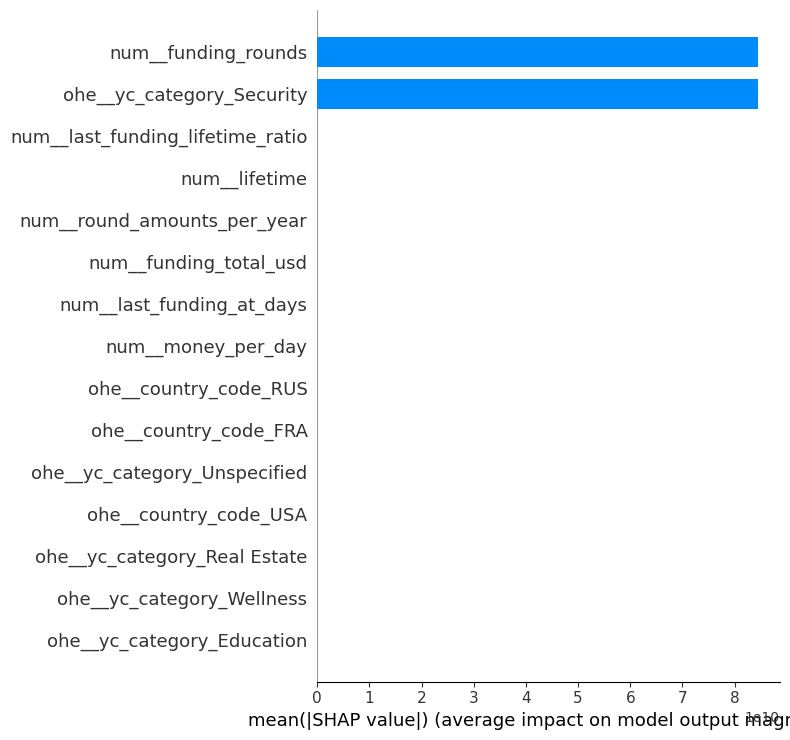

In [139]:
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=features_names, plot_type="bar", max_display=15)

Выведем результат на скрине для ускорения.
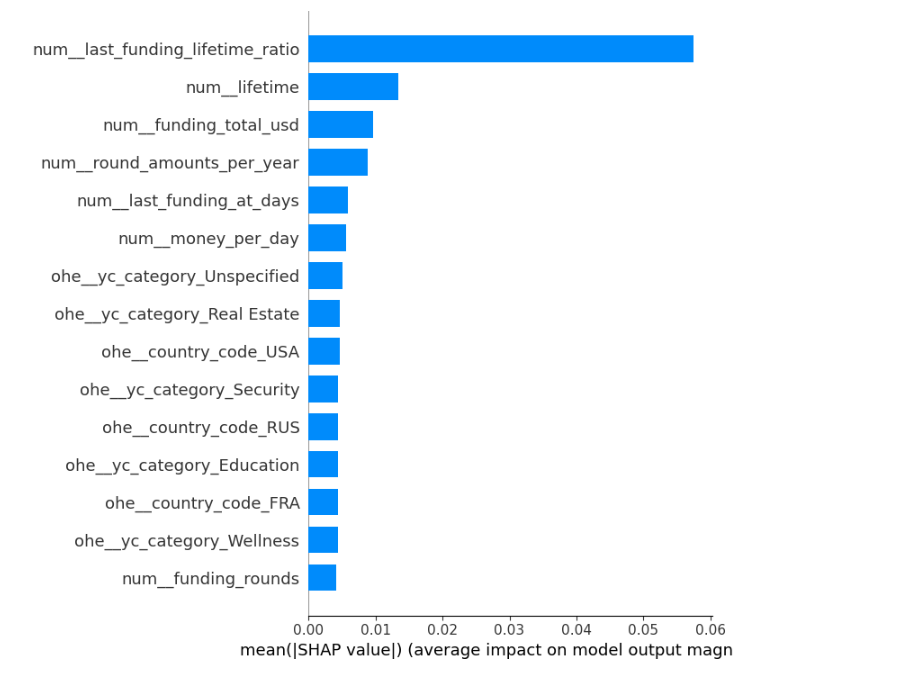

In [140]:
# Получаем ожидаемое (базовое) значение предсказания модели 
base_value = explainer.expected_value

# Создаем объект shap.Explanation
explainer_obj = shap.Explanation(values=shap_values,
                                 base_values=base_value,
                                 data=X_test_preprocessed,
                                 feature_names=features_names)

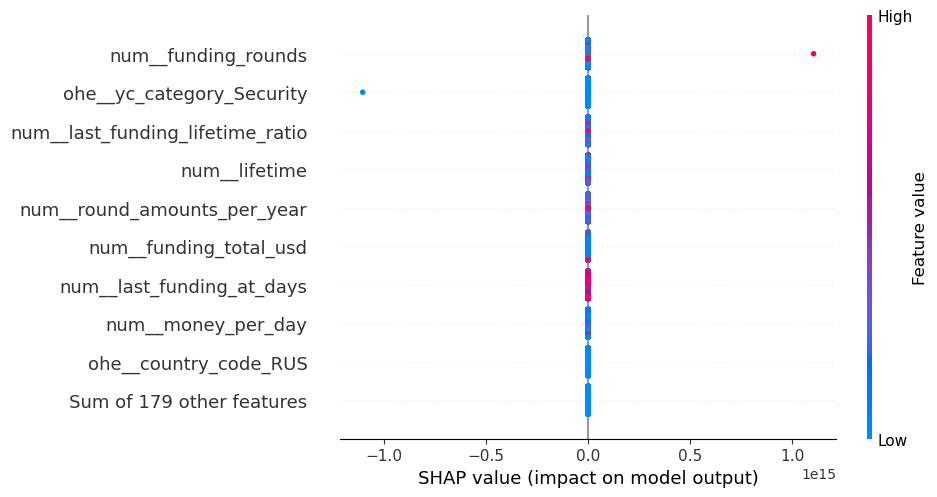

In [141]:
shap.plots.beeswarm(explainer_obj, max_display=10)

Выведем результат на скрине для ускорения
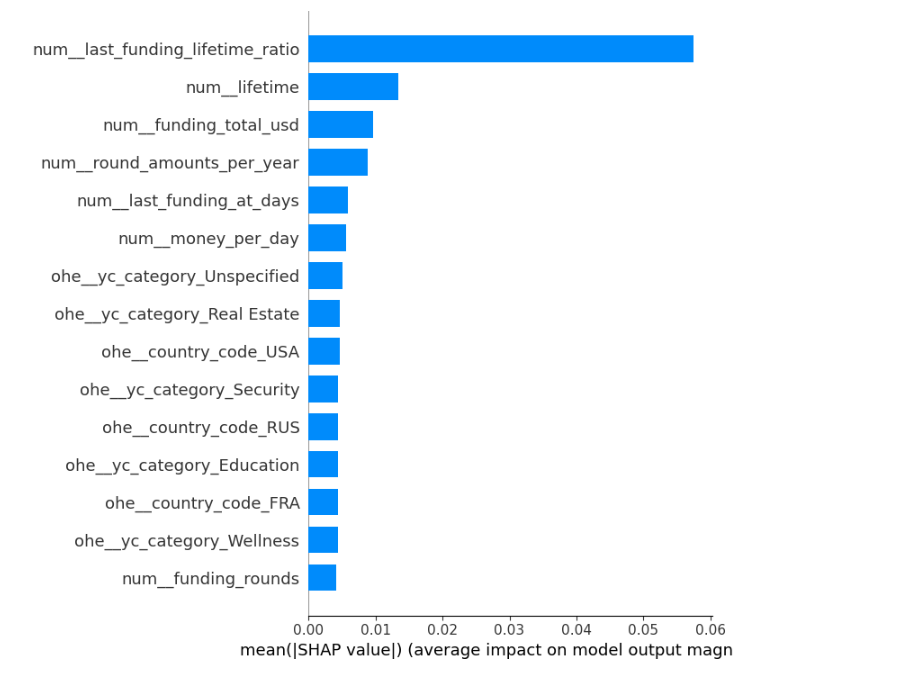

Выделим 3 наболее ключевых признака
 - основной признак влияющий на модель lifetime. Причем его влияние ассиметрично. Высокие значения признака незначительно снижают вероятность закрытия стартапа, при этом низкие значения серьезно влияют на рост вероятности закрытия.
 - высокие значения признака last_funding_at_days значительно снижают вероятность закрытия, низкие значительно повышают. Влияние практически симметричное
 - низкие значения(особенно выбросы) funding_total_usd значительно влияют на рост вероятности закрытия стартапа.

In [142]:
# для примера посмотрим оценку влияния признака для первого наблюдения.
explainer_obj[0]

.values =
array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.02687908,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.     

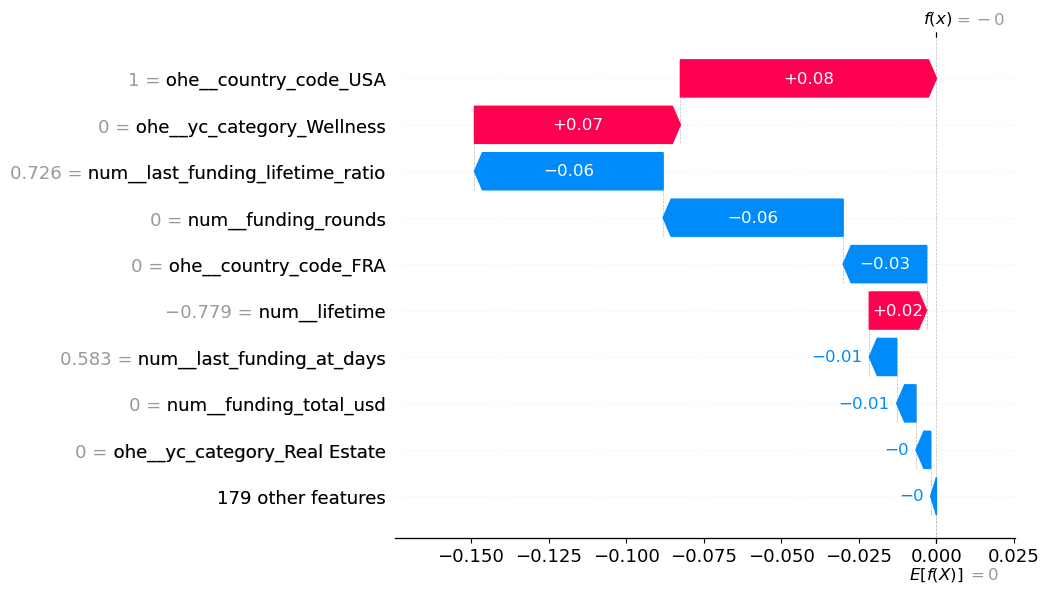

In [143]:
shap.plots.waterfall(explainer_obj[0])

## Отчет по итогам исследования:


Цель проекта - разработать модель для предсказания успешности стартапа (закроется или нет).

2. Дополнительные задачи проекта:
- Выделить важные компоненты из данных, влияющие на работу стартапов.
- На основе данных и графиков сформулировать рекомендации позволяющие повысить шанс на успех стартапа.
- Подготовить отчет по исследованию.

3. Источники данных

    Тренировочный набор (около 53к записей). Набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01' kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
    Тестовый набор. kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета. kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате. name - идентификатор (название) стартапа в тестовом наборе. status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].
    
4. Реализованые шаги проекта:

    4.1 Загружены данные, проведена проверка признаков описанию.
    
    4.2 Предварительная обработка данных. Устранены пропуски и дубликаты. Форматы приведены в соответствие. Укрупнен категориальный признак category_list данные записаны в столбец yc_category. Данные признака last_funding_at преобразованы в числовой формат и записаны в отдельный столбец last_funding_at_days.
    
    4.3 Проведен разведочный анализ, в том числе стат анализ количественных признаков и их распределений в разрезе целевого признака. Для действующих стартапов наблюдаем чуть более высокие значения медианы и среднего.
    
    4.4 Разработаны новые синтетические признаки
     - разница в днях между последним раундом и датой выгрузки
     - соотношение между числом дней с последнего рауда и даты выгрузки / life_time
     - разница в днях между первым и последним раундом
     - средний чек привлечения
     - количество раундов на 1 год существования
     - средняя скорость привлечения денег в день
     - разница между датой основания и первым привлечением. Признак, допускающий утечку (не используется в обучении).
     
    4.5. Проведена проверка признаков на мультиколлинеарность, по итогам которой проведен финальный отбор обучающих признаков.
    
    4.6 Собран пайплан обработки данных и перебора гиперпараметров. 
    
    4.7 Проведена итоговая оценка качества предсказания лучшей модели на кросс-вадидации.
    
    4.8 Сформированы предсказания на тестовом датасете
    
    4.9. Проведен анализ важности признаков лучшей модели.
    
    4.10. Подготовлен профиль действующего стартапа.
    
    4.11 Подготовлен отчет по исследованию.

5. Использованные модели.

В предыдущих версиях проекта были попробованы 
 - DecisionTreeClassifier с диапазоном гиперпараметров 'models__max_depth': range(2, 6), 'models__max_features': range(2, 6),
 - KNeighborsClassifier с диапазоном гиперпараметров  'models__n_neighbors': range(2, 10)
 - SVC
 - LogisticRegression 'models__C': range(1, 5)
    Однако, во всех случаях наилучих результатов удавалось получить используя HistGradientBoostingClassifier с диапазоном гиперпараметров 'models__max_iter': range(50, 200, 50),    'models__learning_rate': [0.01, 0.1, 0.2], 
    В пайплайне итоговой версии проекта используется именно этот класс моделей. 

6. Выводы и рекомендации:
Сформулируем профиль действующего стартапа:


7. Предложения по улучшению модели:
- Использовать более точные методы работы с текстом для более точного и распеределенного укрупнения категорий (LLM-решения)
- Использовать методы автоматической генерации синтетических признаков
- Применить иные метоты оценки отбора признаков, например SelectKBest.
- Использовать семплеры для устранения дисбаланса классов.
- Посмотреть статьи и отчеты по теме "жизнеспособности" стартапов для обогащения данными/нестандартного решения задачи.